In [75]:
from typing import List, Optional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import pickle
import time
import requests
import gdown

# Funkcje pomocnicze/konfiguracja

In [41]:
np.random.seed(308171)

In [42]:
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()

In [43]:
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["figure.figsize"] = (8, 6)

In [44]:
import logging

log_file_name = "analiza" + time.strftime("%Y%m%d") + ".log"
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.FileHandler("analiza.log", "a"), logging.StreamHandler()],
)

In [45]:
from functools import wraps

if not os.path.exists("data/pickled"):
    os.makedirs("data/pickled")


def auto_pickle(version=1, unique_name=""):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            # Generate a filename based on the function name and arguments
            function_args = ""
            for arg in args:
                try:
                    arg_hash = hash(arg)
                except TypeError:
                    arg_hash = hash(str(arg))
                function_args += str(arg_hash)

            file_path = f"data/pickled/{func.__name__}_{unique_name}_v{version}_.pkl"

            # Check if the pickled file exists
            if os.path.exists(file_path):
                logging.info(f"Loading '{file_path}' from file.")
                try:
                    result = pd.read_pickle(file_path)
                    logging.info(f"Loaded '{file_path}' from file pandas type.")
                except ValueError:
                    # Fallback if not a pandas object
                    with open(file_path, "rb") as file:
                        result = pickle.load(file)
                    logging.info(f"Loaded '{file_path}' from file pickle type.")
            else:
                # Call the function and pickle the result
                result = func(*args, **kwargs)
                logging.info(f"Saving '{file_path}' to file.")
                if isinstance(result, (pd.DataFrame, pd.Series)):
                    result.to_pickle(file_path)
                    logging.info(f"Saved '{file_path}' to file pandas type.")
                else:
                    with open(file_path, "wb") as file:
                        pickle.dump(result, file)
                        logging.info(f"Saved '{file_path}' to file pickle type.")
            return result

        return wrapper

    return decorator

In [46]:
def download_file(
    url: str,
    destination_folder: str,
    local_filename: Optional[str] = None,
    verify=False,
):
    """
    Downloads a file from a specified URL into a specified directory.
    """
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    local_filename = (
        os.path.join(destination_folder, local_filename)
        if local_filename
        else os.path.join(destination_folder, url.split("/")[-1])
    )
    if not os.path.exists(local_filename):
        print(f"Downloading data to {local_filename}...")
        # NOTE to verify is set to False because of SSL certificate issues
        response = requests.get(url, stream=True, verify=verify)
        total_size_in_bytes = int(response.headers.get("content-length", 0))
        block_size = 1024  # 1 Kibibyte
        progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)
        with open(local_filename, "wb") as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()
        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("ERROR, something went wrong")
    return local_filename

# Wczytanie danych

In [47]:
@auto_pickle(unique_name="specified_columns")
def load_data(
    file_path: str,
    columns_to_keep: Optional[List[str]] = None,
    chunksize: int = 1000,
    total_rows: int = 2360655,
) -> pd.DataFrame:
    """
    Loads data from a JSON file in chunks and returns a DataFrame.

    :param file_path: The path to the JSON file.
    :type file_path: str
    :param columns_to_keep: A list of column names to keep, defaults to None which means all columns are kept.
    :type columns_to_keep: List[str], optional
    :param chunksize: The number of rows per chunk to read at a time, defaults to 1000.
    :type chunksize: int
    :param total_rows: The total number of rows in the file, defaults to 2360655. This is used to estimate progress.
    :type total_rows: int
    :return: A pandas DataFrame containing the loaded data.
    :rtype: pandas.DataFrame

    This function loads data from a specified JSON file, optionally filtering for specified columns,
    in chunks to manage memory usage. It utilizes pandas' read_json function with the 'lines=True'
    and 'compression="gzip"' parameters to efficiently load large, compressed files. The progress of data
    loading is displayed using tqdm if the total number of rows is known.
    """
    chunks = pd.read_json(
        file_path, orient="records", lines=True, chunksize=chunksize, compression="gzip"
    )

    if columns_to_keep is None:
        return pd.concat(
            [
                chunk
                for chunk in tqdm(chunks, desc="Loading Data", total=total_rows / 1000)
            ],
            ignore_index=True,
        )

    return pd.concat(
        [
            chunk[columns_to_keep]
            for chunk in tqdm(
                chunks, desc="Loading Selected Columns", total=total_rows / 1000
            )
        ],
        ignore_index=True,
    )


# Download the data from https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/goodreads_books.json.gz and place it in the data folder
if not os.path.exists("data/goodreads_books.json.gz"):
    download_file(
        "https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/goodreads_books.json.gz",
        "data",
        "goodreads_books.json.gz",
    )


df = load_data(
    file_path="data/goodreads_books.json.gz",
    columns_to_keep=[
        "book_id",
        "title",
        "language_code",
        "series",
        "similar_books",
        "description",
        "url",
    ],
)
df.head()

2024-05-05 17:25:50,046 - INFO - Loading 'data/pickled/load_data_specified_columns_v1_.pkl' from file.
2024-05-05 17:26:02,001 - INFO - Loaded 'data/pickled/load_data_specified_columns_v1_.pkl' from file pandas type.


,book_id,title,language_code,series,similar_books,description,url
0,5333265,W.C. Fields: A Life on Film,,[],[],,https://www.goodreads.com/book/show/5333265-w-...
1,1333909,Good Harbor,,[],"[8709549, 17074050, 28937, 158816, 228563, 112...","Anita Diamant's international bestseller ""The ...",https://www.goodreads.com/book/show/1333909.Go...
2,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",eng,[189911],"[19997, 828466, 1569323, 425389, 1176674, 2627...",Omnibus book club edition containing the Ladie...,https://www.goodreads.com/book/show/7327624-th...
3,6066819,Best Friends Forever,eng,[],"[6604176, 6054190, 2285777, 82641, 7569453, 70...",Addie Downs and Valerie Adler were eight when ...,https://www.goodreads.com/book/show/6066819-be...
4,287140,Runic Astrology: Starcraft and Timekeeping in ...,,[],[],,https://www.goodreads.com/book/show/287140.Run...


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 7 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   book_id        int64 
 1   title          object
 2   language_code  object
 3   series         object
 4   similar_books  object
 5   description    object
 6   url            object
dtypes: int64(1), object(6)
memory usage: 126.1+ MB


In [49]:
# Sprawdzenie ilości pamięci zajmowanej przez poszczególne kolumny w MB
df.memory_usage(deep=True) / 1024**2

Index               0.000126
book_id            18.010368
title             212.760921
language_code     132.328120
series            168.630188
similar_books     288.363770
description      1694.559411
url               269.758849
dtype: float64

Oznaczenie pustych wartości jako NaN

In [50]:
df.memory_usage(deep=True).sum() / 1024**2

2784.4117527008057

In [51]:
df.replace(r"^\s*$", np.nan, regex=True, inplace=True)

In [52]:
df.isna().sum()

book_id                0
title                  7
language_code    1060153
series                 0
similar_books          0
description       412233
url                  524
dtype: int64

In [53]:
df["language_code"].unique()

array([nan, 'eng', 'ger', 'spa', 'en-US', 'ita', 'per', 'en-GB', 'tur',
       'ind', 'mon', 'fre', 'por', 'ara', 'en-CA', 'tha', 'lav', 'jpn',
       'pol', 'swe', 'kor', 'fin', 'msa', 'bul', 'nl', 'gre', 'slo',
       'nor', 'heb', 'hun', 'ben', 'scr', 'zho', 'fil', 'rus', 'lit',
       'rum', 'cze', 'dan', 'slv', 'nno', 'pes', 'hye', 'nob', 'cat',
       'en', 'vie', 'nep', 'mar', 'srp', 'urd', 'guj', 'est', 'sqi',
       'ukr', 'afr', 'mul', 'grc', 'kat', 'mkd', 'hin', 'tam', 'mus',
       '--', 'bos', 'enm', 'gla', 'isl', 'glg', 'mal', 'kur', 'wel',
       'pt-BR', 'crh', 'tel', 'es-MX', 'kan', 'mya', 'fao', 'aze', 'ota',
       'arw', 'pra', 'tgl', 'lat', 'dum', 'eus', 'sin', 'mlt', 'ada',
       'apa', 'udm', 'peo', 'bel', 'iro', 'nld', 'ori', 'smn', 'amh',
       'tut', 'frs', 'arg', 'ang', 'abk', 'epo', 'snd', 'pan', 'egy',
       'dut', 'vls', 'jav', 'tlh', 'din', 'gle', 'alg', 'gsw', 'nah',
       'her', 'aus', 'aka', 'chm', 'ace', 'oci', 'ast', 'kok', 'tib',
       'frm', '

In [54]:
language_code_counts = df["language_code"].value_counts()
language_code_counts

language_code
eng      708457
en-US     91452
en-GB     58358
spa       54524
ita       50902
          ...  
hat           1
ltz           1
btk           1
sla           1
lao           1
Name: count, Length: 226, dtype: int64

In [55]:
len(df[df["language_code"] == "pol"])

6576

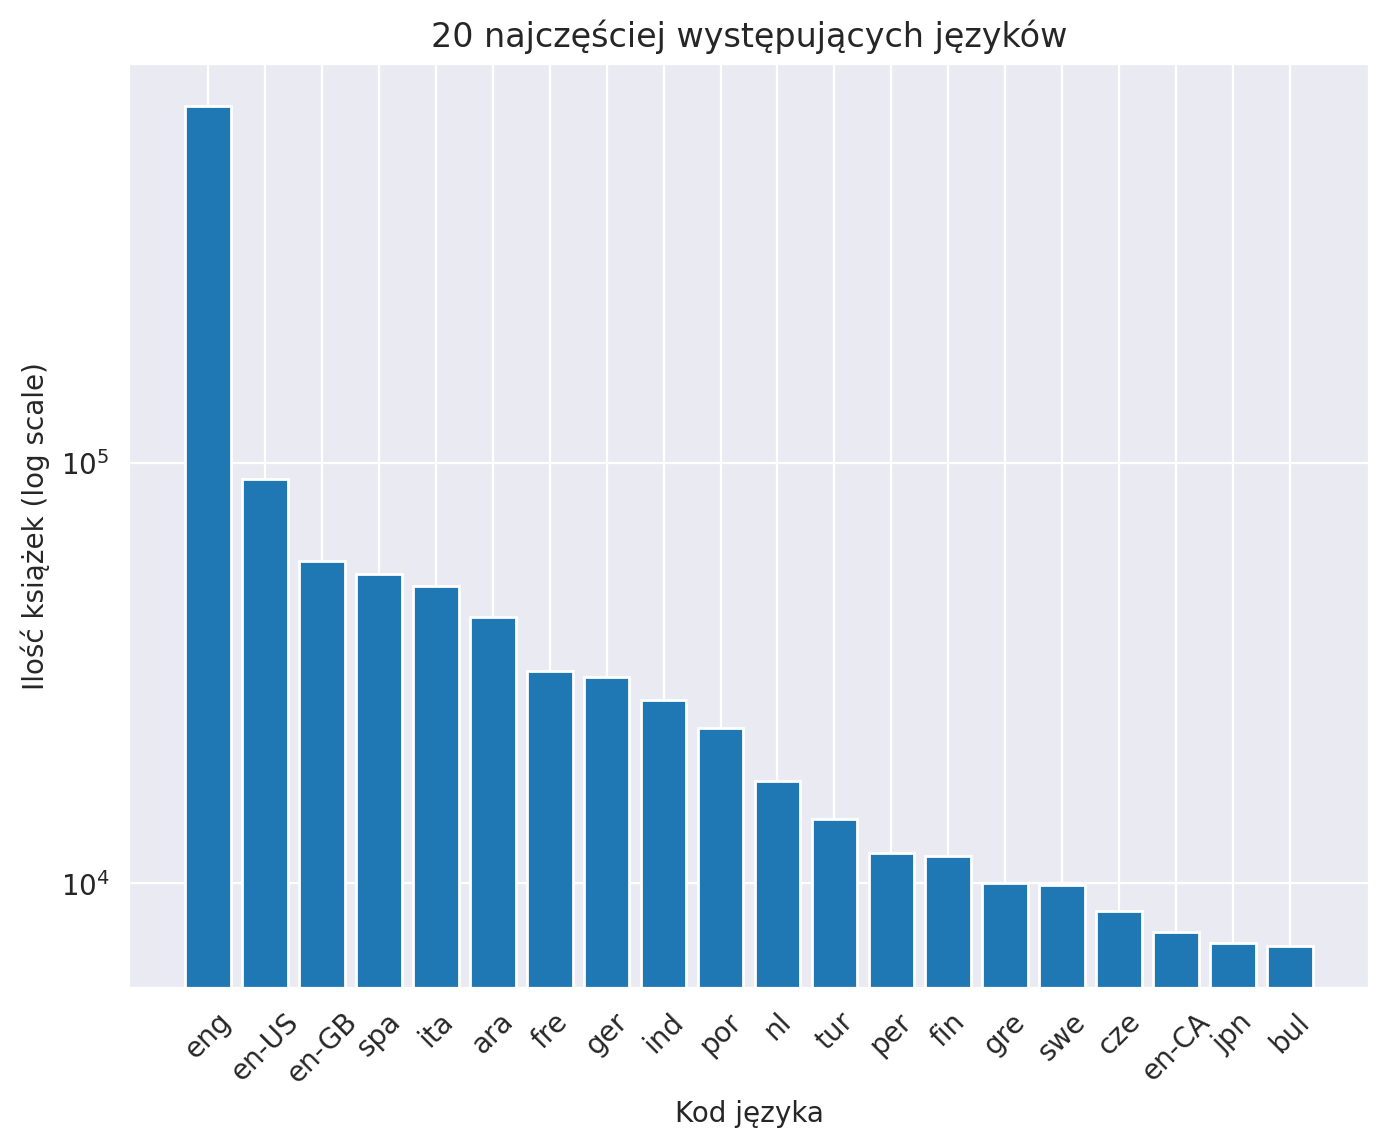

In [56]:
language_code_sorted = language_code_counts.nlargest(20).sort_values(ascending=False)

plt.figure()
plt.bar(language_code_sorted.index, language_code_sorted.values, log=True)
plt.xlabel("Kod języka")
plt.ylabel("Ilość książek (log scale)")
plt.title("20 najczęściej występujących języków")
plt.xticks(rotation=45)
plt.show()

Procentowy udział opisów książek, które są puste

In [57]:
df["description"].isna().sum() / len(df) * 100

17.462653373745844

In [58]:
df["description_len"] = df["description"].apply(
    lambda x: len(x) if x is not np.NaN else 0
)
df["description_len"].describe()

count    2.360655e+06
mean     6.957039e+02
std      6.024389e+02
min      0.000000e+00
25%      2.460000e+02
50%      6.470000e+02
75%      1.003000e+03
max      6.489700e+04
Name: description_len, dtype: float64

[Ilość kubełków](https://medium.datadriveninvestor.com/how-to-decide-on-the-number-of-bins-of-a-histogram-3c36dc5b1cd8)
[Inne wskaźniki](https://medium.com/@maxmarkovvision/optimal-number-of-bins-for-histograms-3d7c48086fde)

In [59]:
def freedman_diaconis_bins(data, column_name):
    n = len(data)
    q1 = data[column_name].quantile(0.25)
    q3 = data[column_name].quantile(0.75)
    iqr = q3 - q1
    bin_width = (2 * iqr) / (n ** (1 / 3))
    return math.ceil((data[column_name].max() - data[column_name].min()) / bin_width)


def sturges_bins(data):
    return 1 + math.ceil(math.log2(len(data)))


def doane_optimal_bins(data) -> int:
    n = len(data)

    # coefficient
    sg1 = np.sqrt(6.0 * (n - 2.0) / ((n + 1.0) * (n + 3.0)))

    # skewness
    skew = np.mean(((data - np.mean(data)) / np.std(data)) ** 3)

    # skewness correction
    Ke = np.log2(1.0 + np.absolute(skew) / sg1)

    width = 1.0 + np.log2(n) + Ke

    nbins = math.ceil((data.max() - data.min()) / width)
    nbins = max(1, nbins)

    return nbins

In [60]:
freedman_diaconis_bins(df, "description_len")

5708

In [61]:
sturges_bins(df)

23

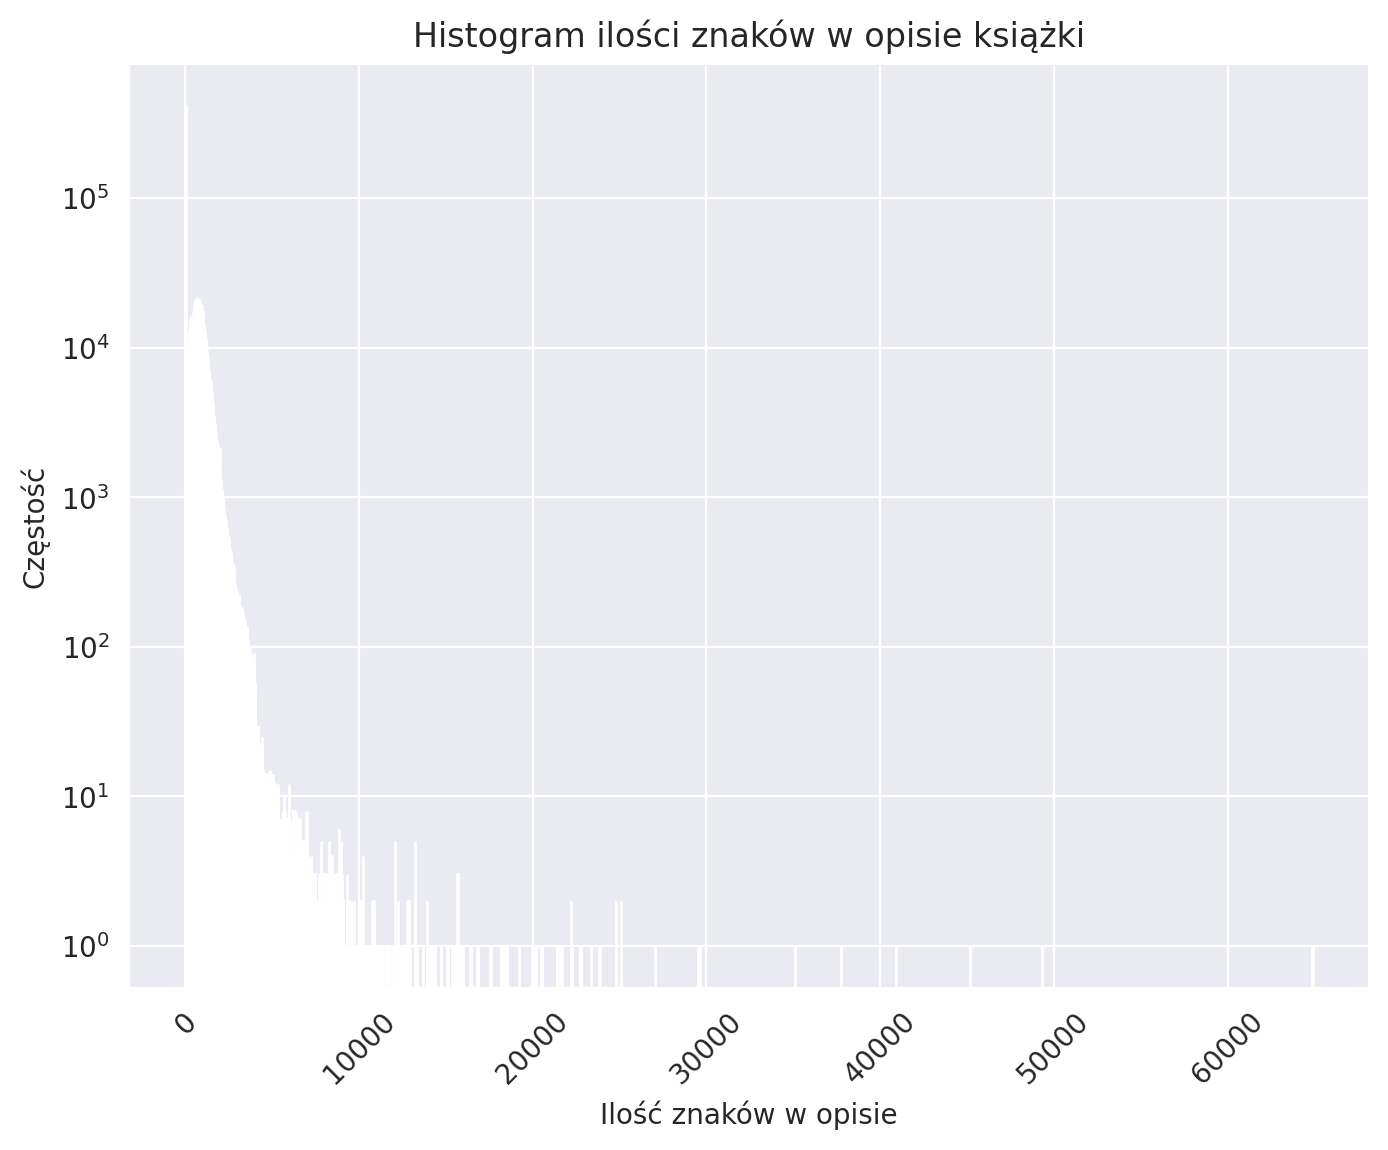

In [62]:
plt.figure()
plt.hist(
    bins=freedman_diaconis_bins(df, "description_len"),
    data=df,
    x="description_len",
    log=True,
)
plt.xlabel("Ilość znaków w opisie")
plt.ylabel("Częstość")
plt.title("Histogram ilości znaków w opisie książki")
plt.xticks(rotation=45)
plt.show()

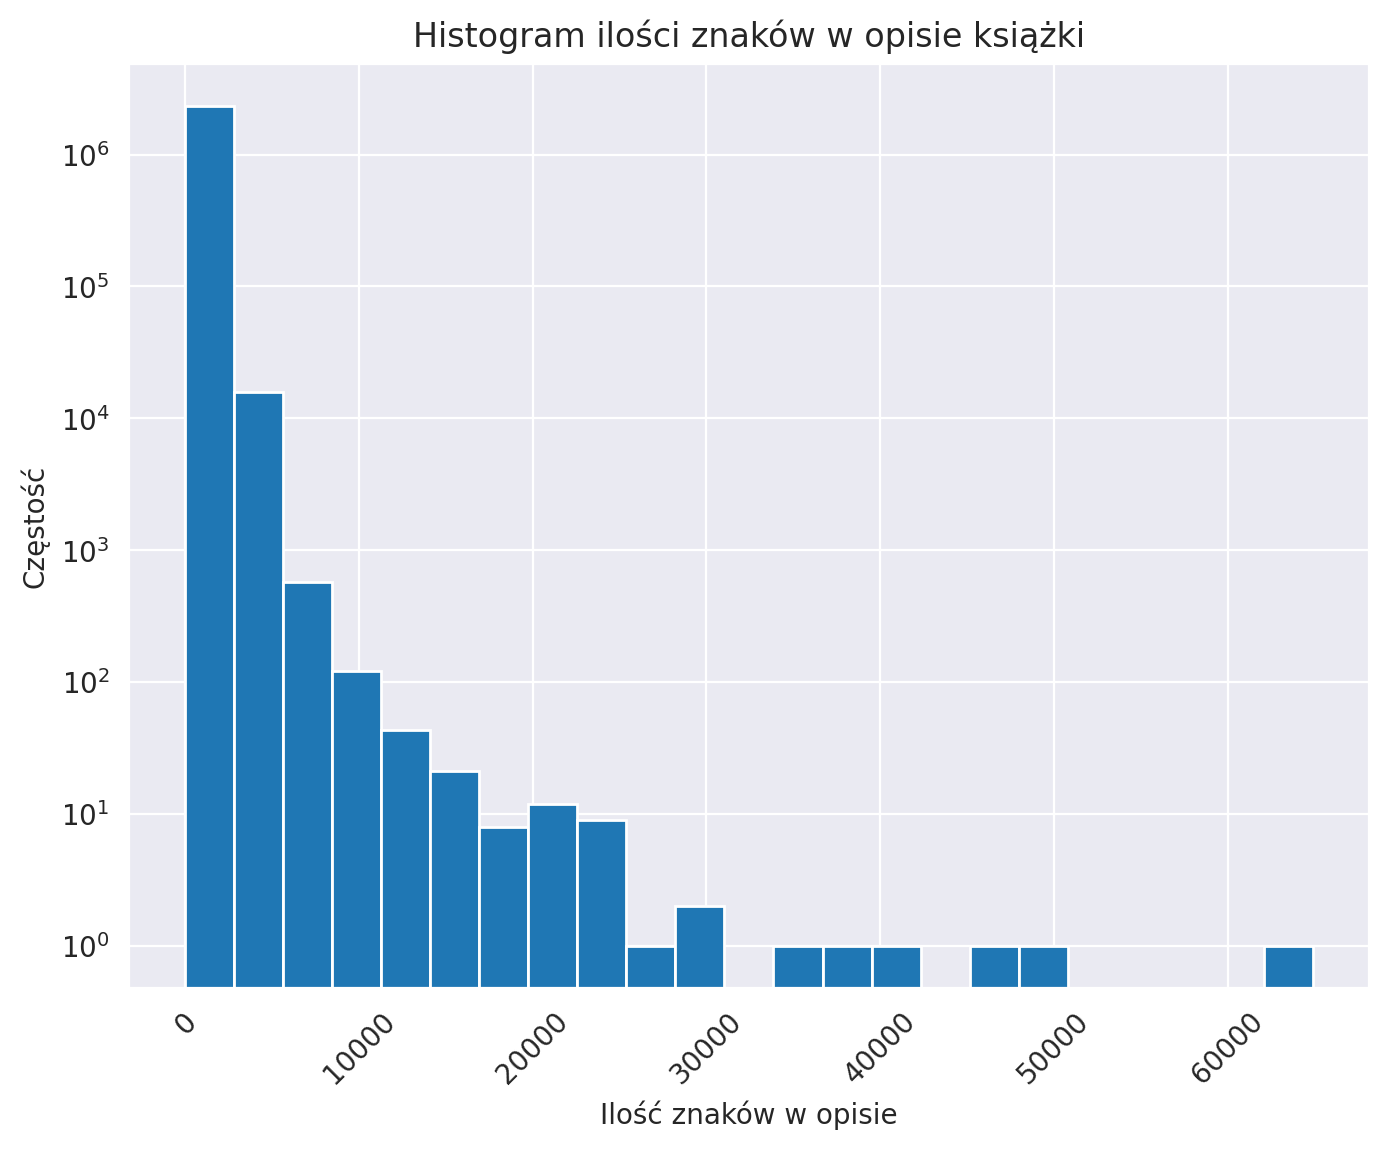

In [63]:
plt.figure()
plt.hist(bins=sturges_bins(df), data=df, x="description_len", log=True)
plt.xlabel("Ilość znaków w opisie")
plt.ylabel("Częstość")
plt.title("Histogram ilości znaków w opisie książki")
plt.xticks(rotation=45)
plt.show()

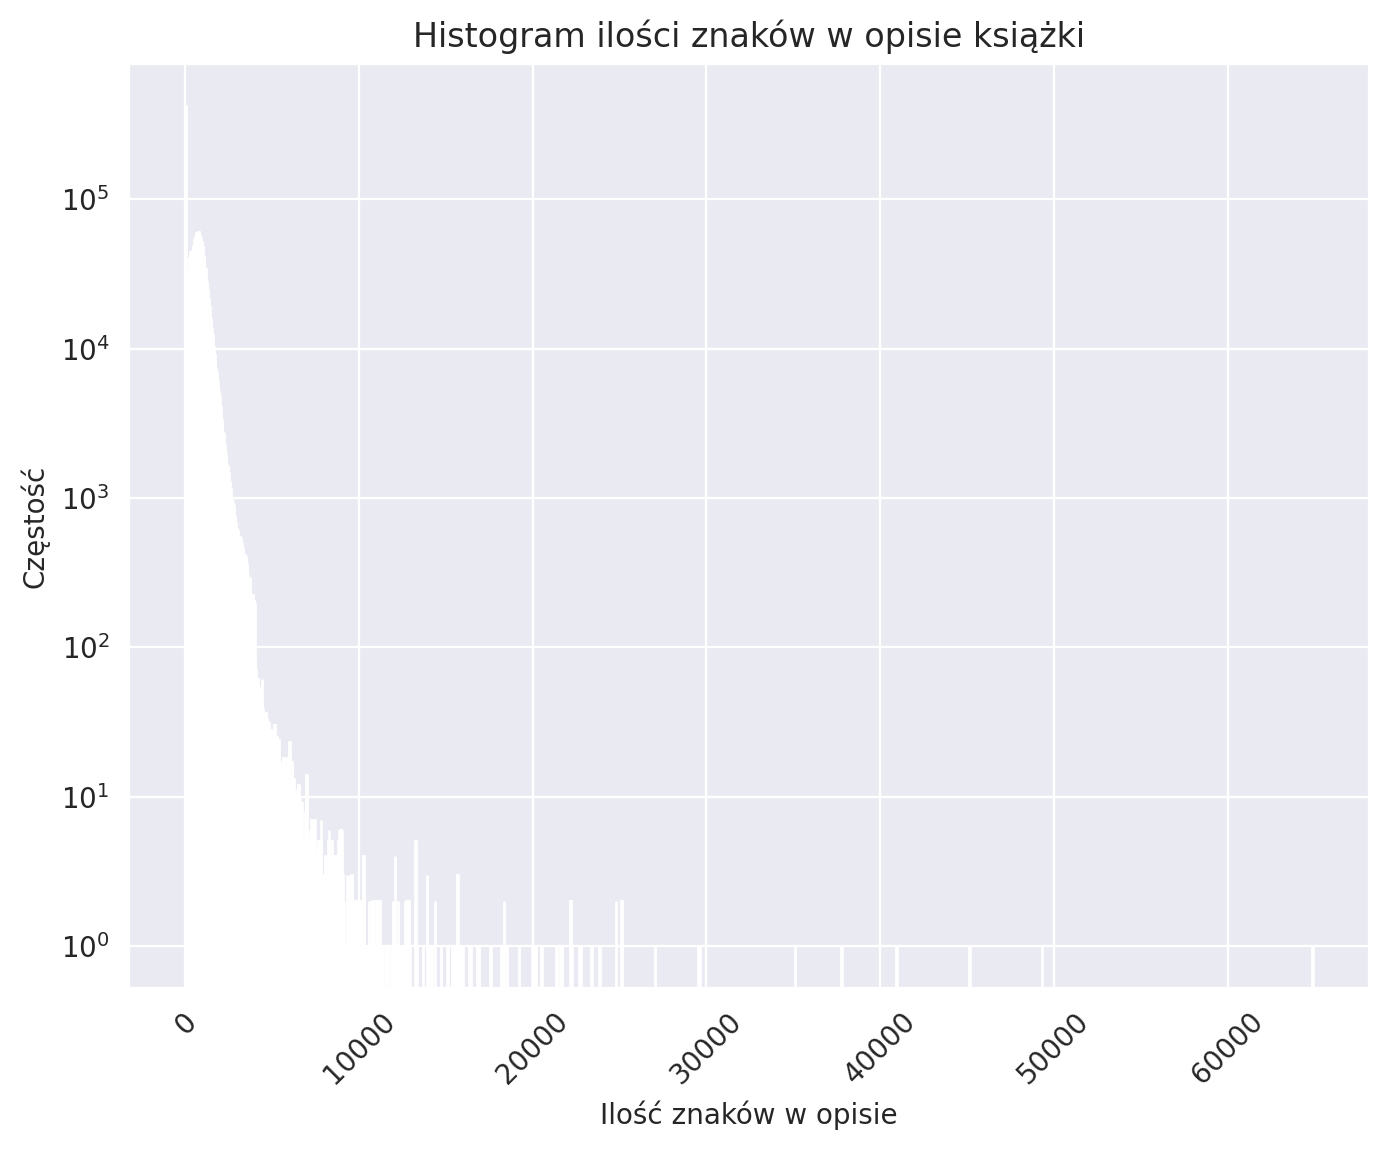

In [64]:
plt.figure()
plt.hist(
    bins=doane_optimal_bins(df["description_len"]),
    data=df,
    x="description_len",
    log=True,
)
plt.xlabel("Ilość znaków w opisie")
plt.ylabel("Częstość")
plt.title("Histogram ilości znaków w opisie książki")
plt.xticks(rotation=45)
plt.show()

In [65]:
df["description_len"].skew()

3.639472045003378

In [66]:
df["description_len"].kurtosis()

141.977915392944

In [67]:
len(df[df["description_len"] == 0])

412233

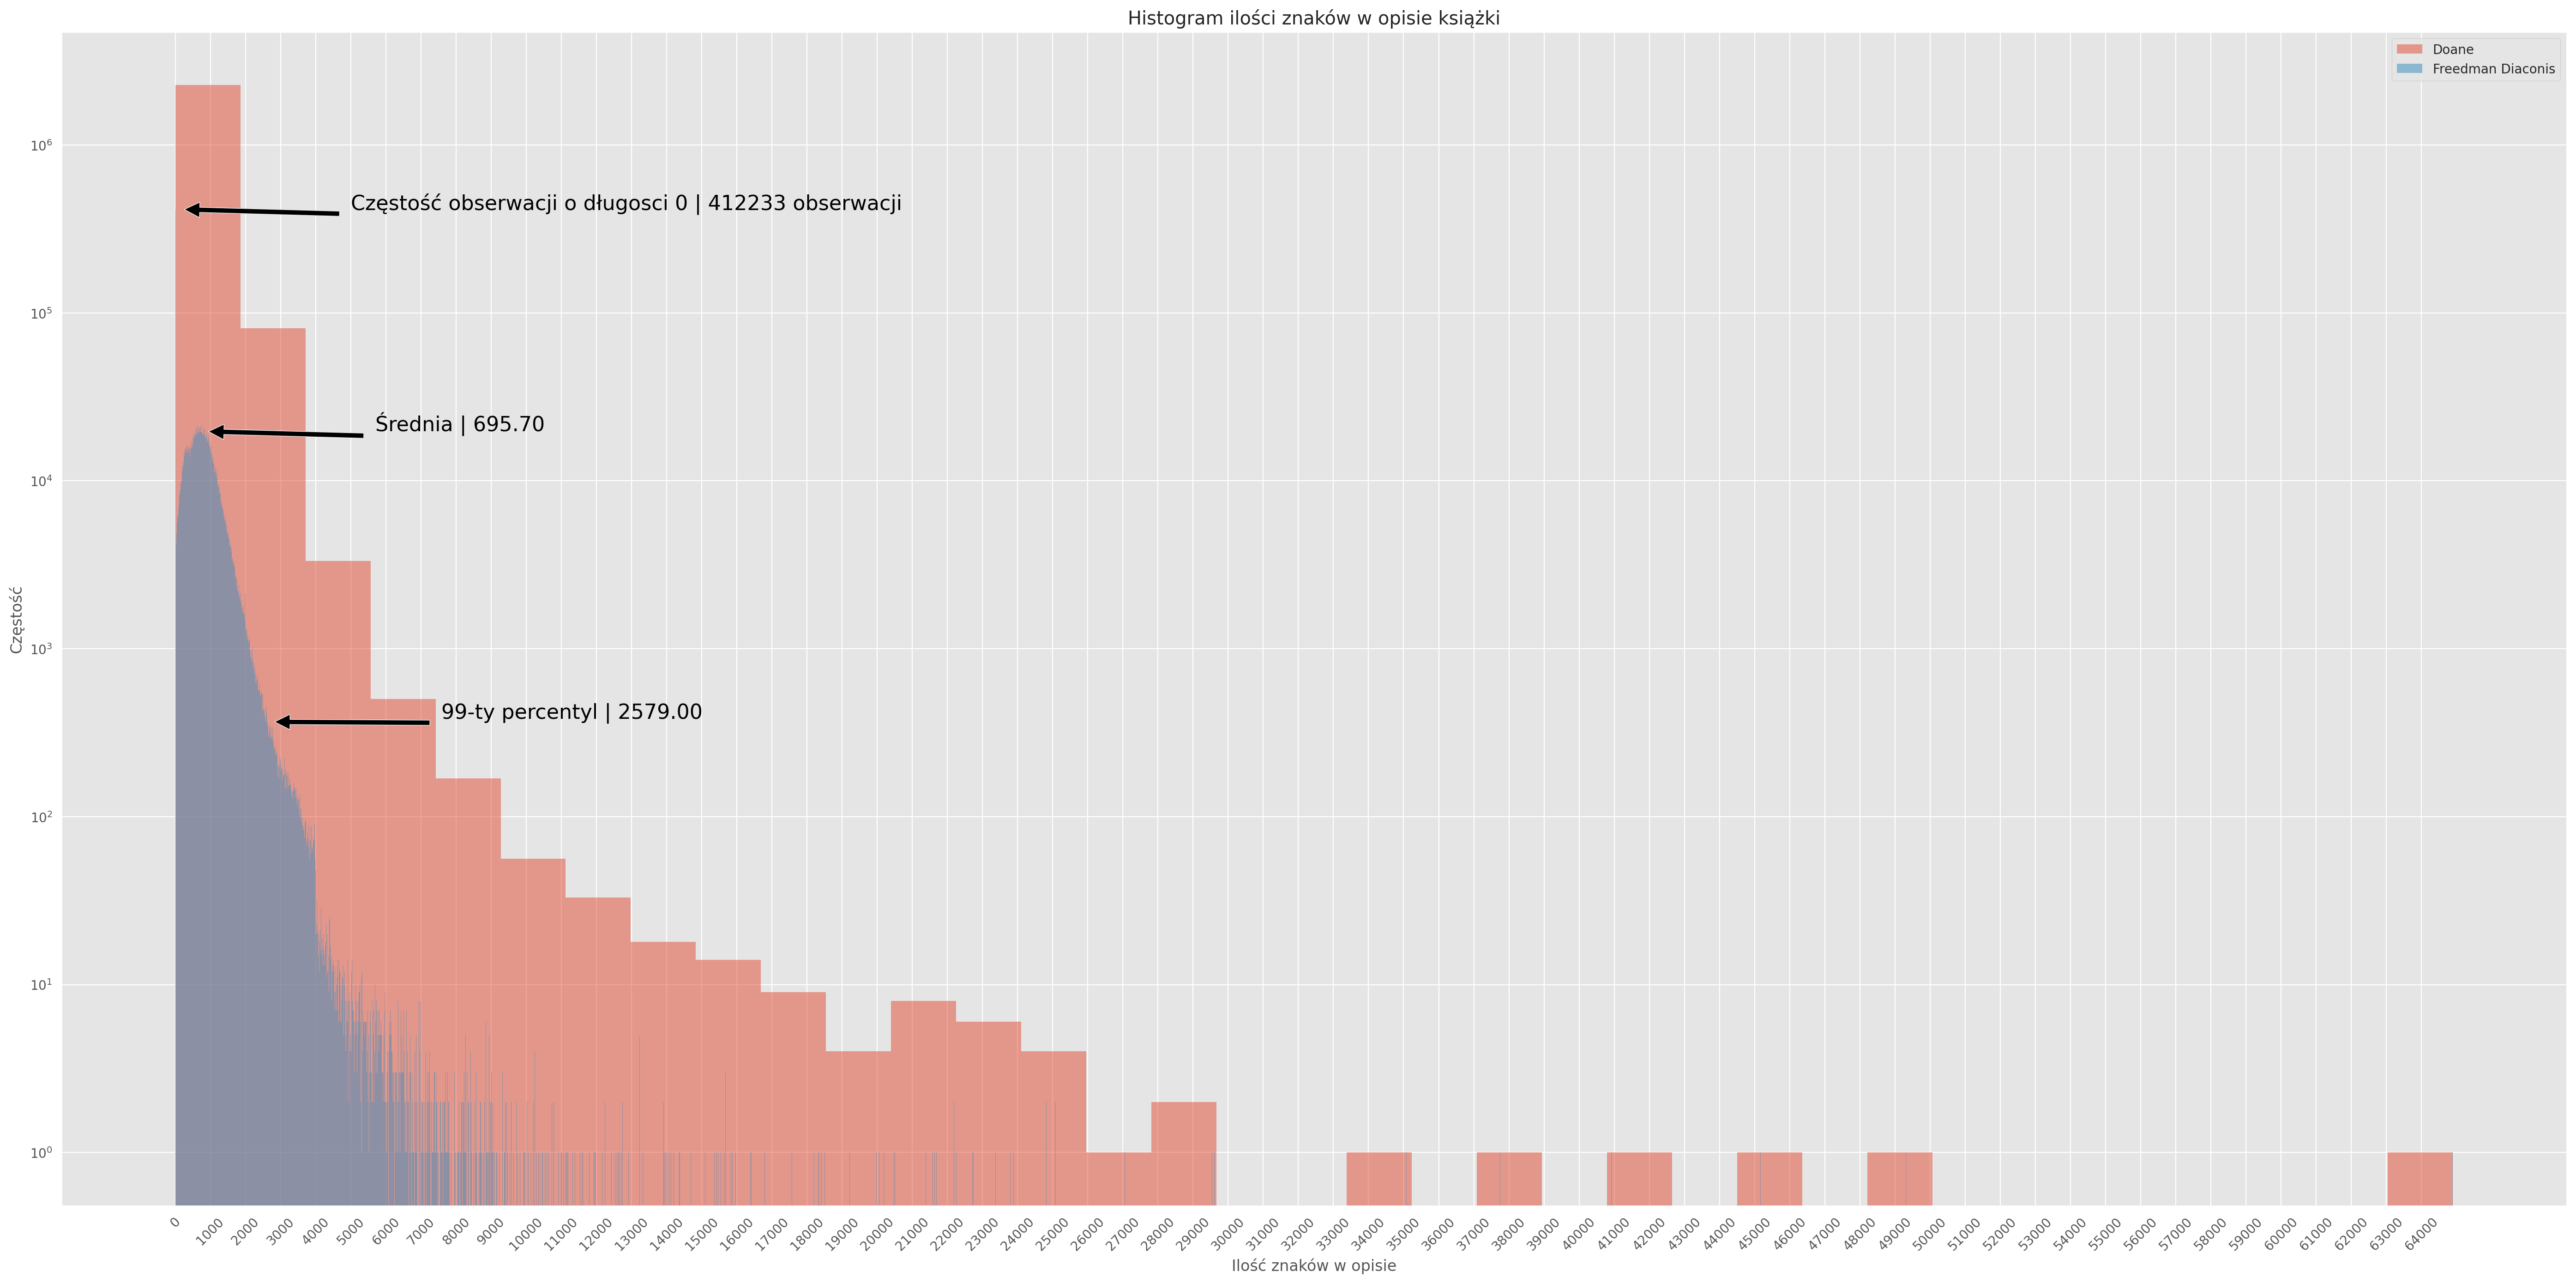

In [68]:
# Styl wykresu
plt.style.use("ggplot")

# Tworzenie histogramu
plt.figure(figsize=(28, 14))
plt.hist(
    df["description_len"],
    bins=np.histogram_bin_edges(df["description_len"], bins="doane").size,
    alpha=0.5,
    label="Doane",
    log=True,
    edgecolor="black",
    linewidth=0,
)
n, bins, patches = plt.hist(
    df["description_len"],
    bins=np.histogram_bin_edges(df["description_len"], bins="fd"),
    alpha=0.5,
    label="Freedman Diaconis",
    log=True,
    edgecolor="black",
    linewidth=0,
)
# Etykiety osi i tytuł
plt.xlabel("Ilość znaków w opisie")
plt.ylabel("Częstość")
plt.title("Histogram ilości znaków w opisie książki")

# Ustawienia dla osi X
tick_positions = range(0, int(df["description_len"].max()) + 1, 1000)
tick_labels = [str(x) for x in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)

# Dodawanie legendy
plt.legend()

x_pos = (bins[0] + bins[1]) / 2  # Środek pierwszego przedziału
y_pos = n[0]  # Wysokość pierwszego słupka

# Dodawanie strzałek
plt.annotate(
    "Częstość obserwacji o długosci 0 | 412233 obserwacji",
    xy=(x_pos, y_pos),
    xytext=(x_pos + 5000, y_pos),
    arrowprops=dict(facecolor="black", shrink=0.05),
    fontsize=16,
    color="black",
)

mean_value = df["description_len"].mean()
bin_index = np.digitize(mean_value, bins) - 1  # Znajduje odpowiedni przedział
y_pos = n[bin_index]  # Wysokość tego słupka

plt.annotate(
    f"Średnia | {mean_value:.2f}",
    xy=(mean_value, y_pos),
    xytext=(mean_value + 5000, y_pos + 20),
    arrowprops=dict(facecolor="black", shrink=0.05),
    fontsize=16,
    color="black",
)

percentile_99 = np.percentile(df["description_len"], 99)
per_bin_index = np.digitize(percentile_99, bins) - 1  # Znajduje odpowiedni przedział
y_pos = n[per_bin_index]  # Wysokość tego słupka

plt.annotate(
    f"99-ty percentyl | {percentile_99:.2f}",
    xy=(percentile_99, y_pos),
    xytext=(percentile_99 + 5000, y_pos + 20),
    arrowprops=dict(facecolor="black", shrink=0.05),
    fontsize=16,
    color="black",
)

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()

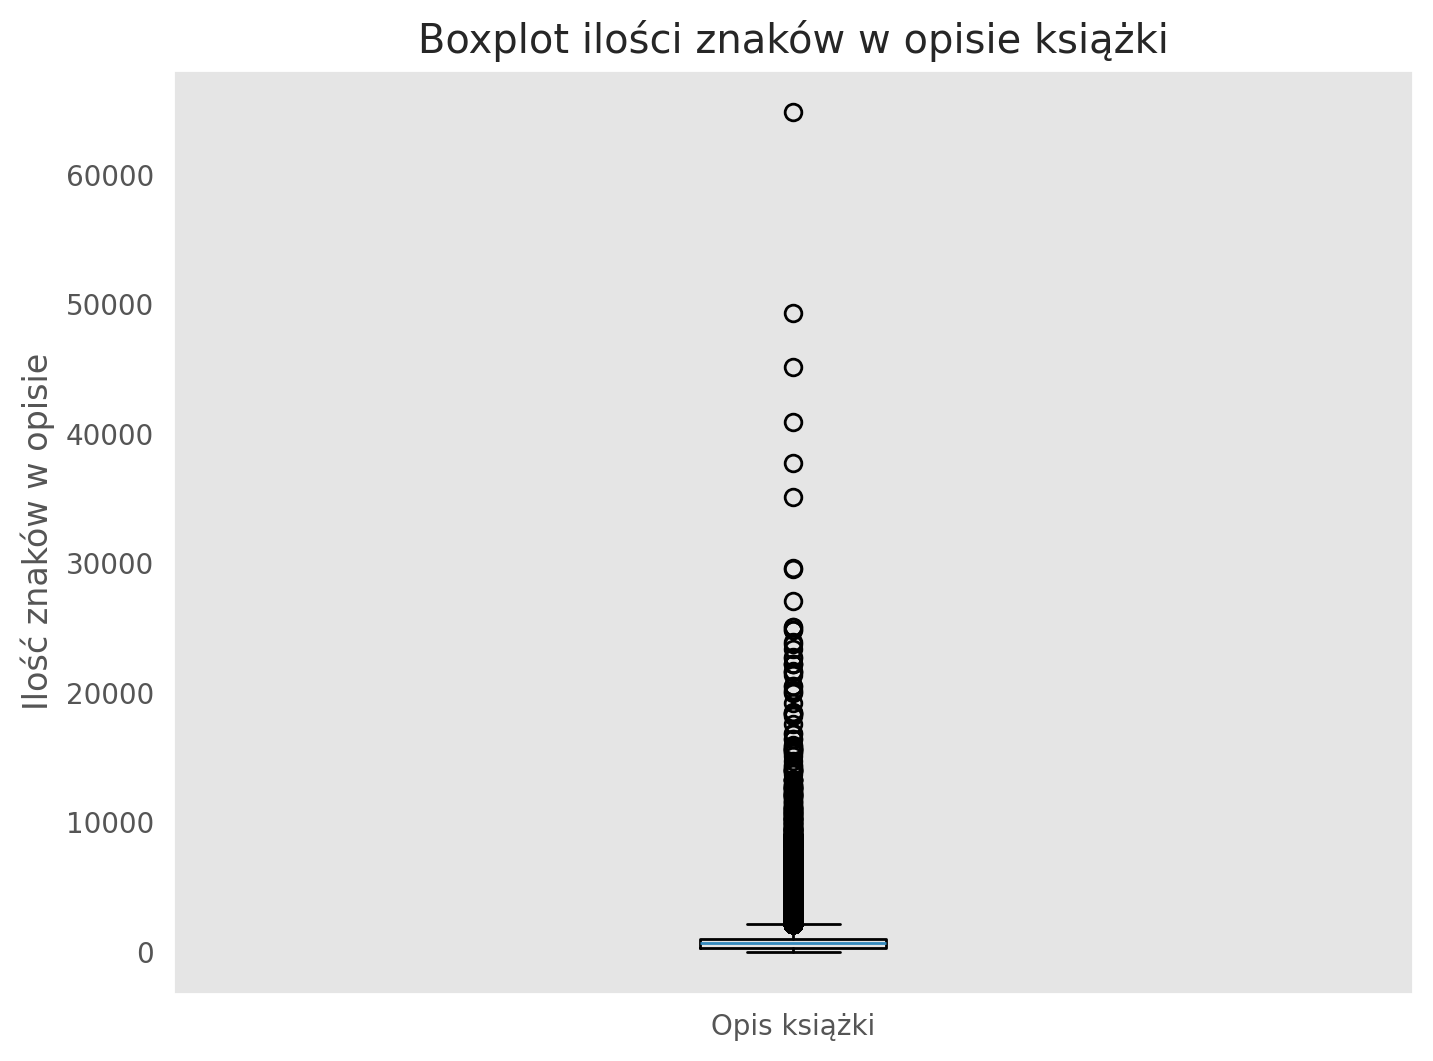

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the boxplot
plt.figure()
plt.boxplot(data=df, x="description_len")
plt.ylabel("Ilość znaków w opisie")
plt.title("Boxplot ilości znaków w opisie książki")
plt.xticks([1], ["Opis książki"])
plt.grid(False)
plt.show()

In [70]:
pd.set_option("display.float_format", "{:.2f}".format)
df["description_len"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

count   2360655.00
mean        695.70
std         602.44
min           0.00
1%            0.00
25%         246.00
50%         647.00
75%        1003.00
99%        2579.00
max       64897.00
Name: description_len, dtype: float64

## Oddzielenie książek ze zbyt krótkim opisem

In [71]:
log_lengths = df[df["description_len"] > 0]["description"].apply(
    lambda x: np.log1p(len(x))
)
Q1, Q3 = np.percentile(log_lengths, [25, 75])
IQR = Q3 - Q1

cutoff = Q1 - 1.5 * IQR
cutoff, np.expm1(cutoff)

(4.93202589653904, 137.66013907947402)

In [72]:
bad_description_138 = df[df["description_len"] < 138]
len(bad_description_138)

483726

# Analiza odświeżonych danych

In [77]:
if not os.path.exists("data/new_descriptions.csv"):
    gdown.download(
        "https://drive.google.com/file/d/1MsCeBjg3kV8GoiIcAT7QMD_PadipWabT/view?usp=drive_link", output="data/new_descriptions.csv", quiet=False, fuzzy=True)


fresh_df = pd.read_csv(
    "data/new_descriptions.csv",
)
fresh_df = fresh_df.rename(columns={"ID": "book_id", "Description": "description"})
fresh_df.head()

,book_id,description
0,750454,What do wives expect from their husbands? Some...
1,750456,A young woman losing her vision rides the subw...
2,8217862,"In productive classrooms, teachers don't just ..."
3,24850274,NaN
4,16117516,Free Download


In [34]:
fresh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483748 entries, 0 to 483747
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   book_id      483748 non-null  int64 
 1   description  399162 non-null  object
dtypes: int64(1), object(1)
memory usage: 7.4+ MB


In [35]:
fresh_df["description_len"] = fresh_df["description"].apply(
    lambda x: len(x) if x is not np.NaN else 0
)

In [36]:
fresh_df["description_len"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

count   483748.00
mean       563.33
std        641.37
min          0.00
1%           0.00
25%         59.00
50%        375.00
75%        881.00
99%       2922.53
max      49089.00
Name: description_len, dtype: float64

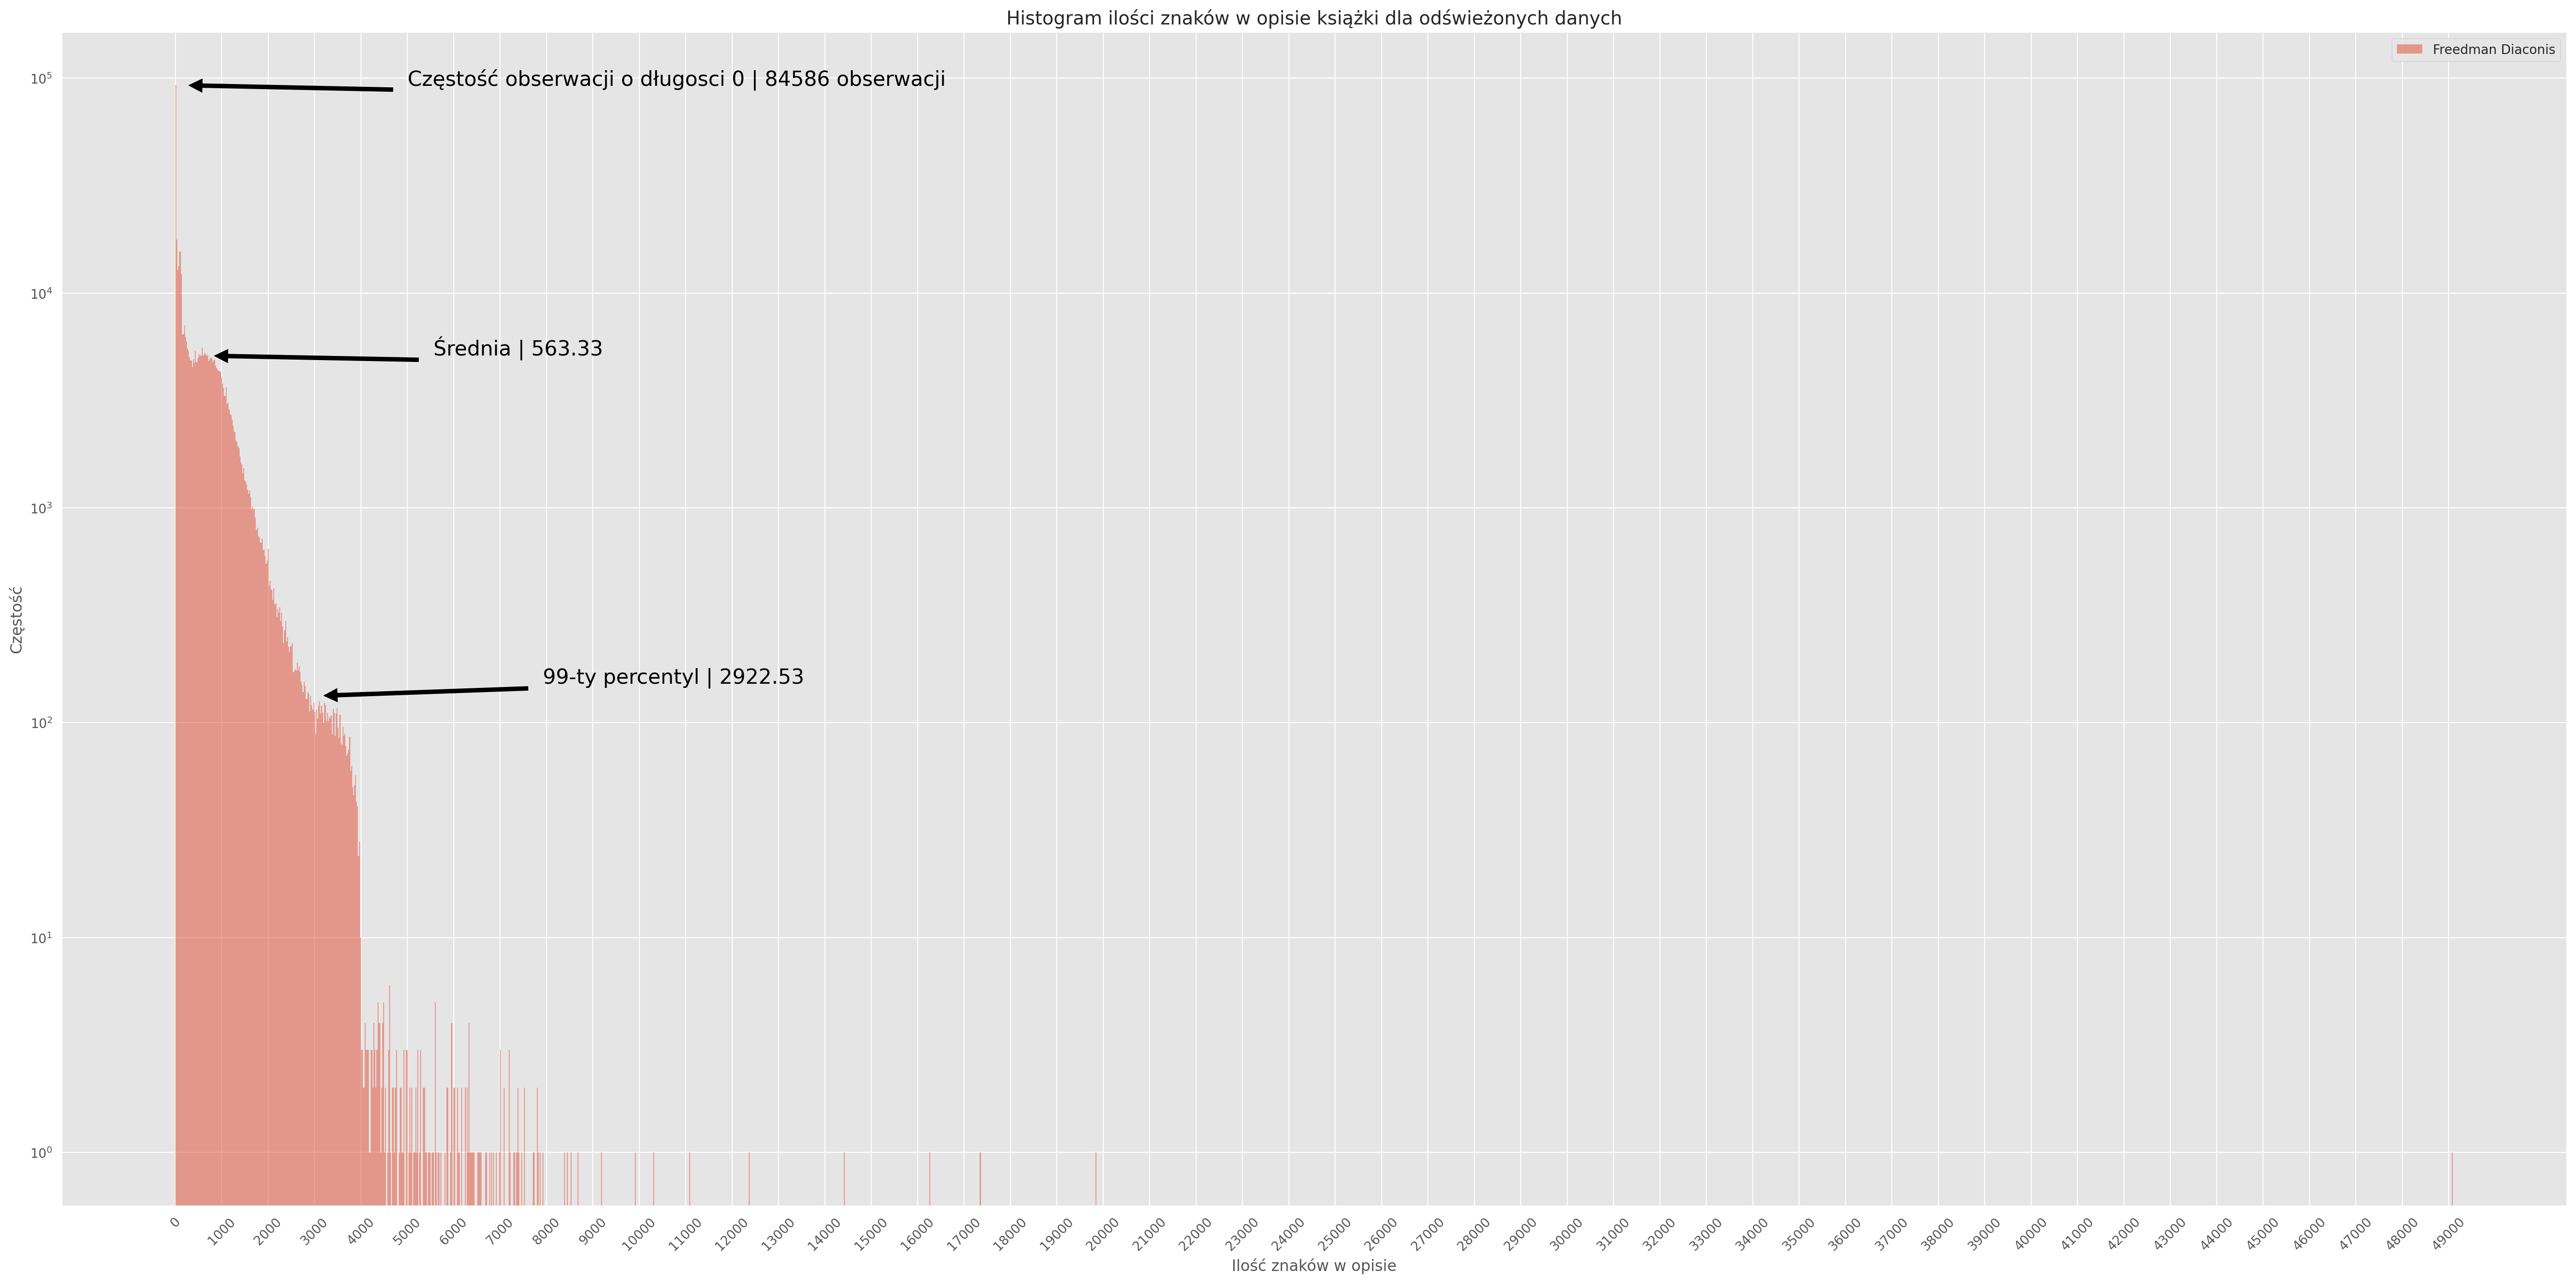

In [37]:
# Styl wykresu
plt.style.use("ggplot")

# Tworzenie histogramu
plt.figure(figsize=(28, 14))

n, bins, patches = plt.hist(
    fresh_df["description_len"],
    bins=np.histogram_bin_edges(fresh_df["description_len"], bins="fd"),
    alpha=0.5,
    label="Freedman Diaconis",
    log=True,
    edgecolor="black",
    linewidth=0,
)
# Etykiety osi i tytuł
plt.xlabel("Ilość znaków w opisie")
plt.ylabel("Częstość")
plt.title("Histogram ilości znaków w opisie książki dla odświeżonych danych")

# Ustawienia dla osi X
tick_positions = range(0, int(fresh_df["description_len"].max()) + 1, 1000)
tick_labels = [str(x) for x in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)

# Dodawanie legendy
plt.legend()

x_pos = (bins[0] + bins[1]) / 2  # Środek pierwszego przedziału
y_pos = n[0]  # Wysokość pierwszego słupka

zero_count = len(fresh_df[fresh_df["description_len"] == 0])

# Dodawanie strzałek
plt.annotate(
    f"Częstość obserwacji o długosci 0 | {zero_count} obserwacji",
    xy=(x_pos, y_pos),
    xytext=(x_pos + 5000, y_pos),
    arrowprops=dict(facecolor="black", shrink=0.05),
    fontsize=16,
    color="black",
)

mean_value = fresh_df["description_len"].mean()
bin_index = np.digitize(mean_value, bins) - 1  # Znajduje odpowiedni przedział
y_pos = n[bin_index]  # Wysokość tego słupka

plt.annotate(
    f"Średnia | {mean_value:.2f}",
    xy=(mean_value, y_pos),
    xytext=(mean_value + 5000, y_pos + 20),
    arrowprops=dict(facecolor="black", shrink=0.05),
    fontsize=16,
    color="black",
)

percentile_99 = np.percentile(fresh_df["description_len"], 99)
per_bin_index = np.digitize(percentile_99, bins) - 1  # Znajduje odpowiedni przedział
y_pos = n[per_bin_index]  # Wysokość tego słupka

plt.annotate(
    f"99-ty percentyl | {percentile_99:.2f}",
    xy=(percentile_99, y_pos),
    xytext=(percentile_99 + 5000, y_pos + 20),
    arrowprops=dict(facecolor="black", shrink=0.05),
    fontsize=16,
    color="black",
)

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()

# Dokładniejsza analiza opisów książek

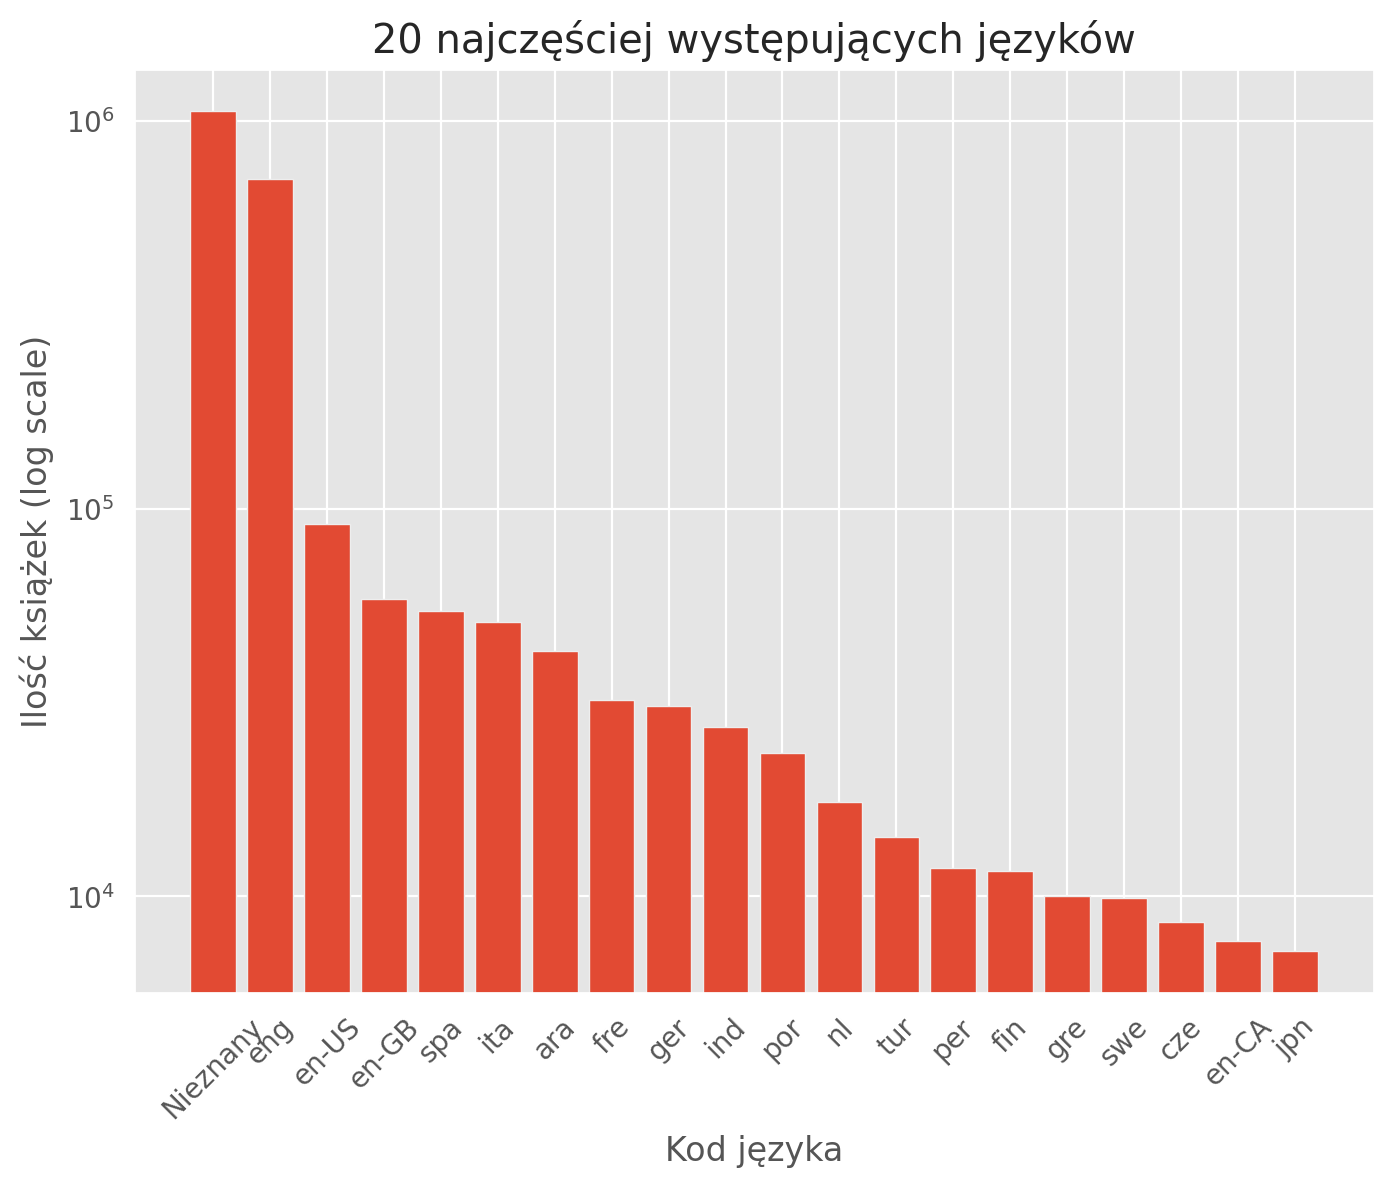

In [38]:
language_code_sorted = (
    df["language_code"]
    .fillna("Nieznany")
    .value_counts()
    .nlargest(20)
    .sort_values(ascending=False)
)


plt.figure()
plt.bar(language_code_sorted.index, language_code_sorted.values, log=True)
plt.xlabel("Kod języka")
plt.ylabel("Ilość książek (log scale)")
plt.title("20 najczęściej występujących języków")
plt.xticks(rotation=45)
plt.show()

In [39]:
import nltk

# Pobierz punkt tokenizer models
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/dawid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
df.dropna(inplace=True, subset=["description"])

In [41]:
english_lang_codes = ["eng", "en-US", "en-GB", "en-CA", "en-IN", "en", np.NaN]

In [42]:
df.drop(df[~df["language_code"].isin(english_lang_codes)].index, inplace=True)

In [43]:
df["language_code"].unique()

array([nan, 'eng', 'en-US', 'en-GB', 'en-CA', 'en', 'en-IN'], dtype=object)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1574391 entries, 1 to 2360653
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   book_id          1574391 non-null  int64 
 1   title            1574387 non-null  object
 2   language_code    790210 non-null   object
 3   series           1574391 non-null  object
 4   similar_books    1574391 non-null  object
 5   description      1574391 non-null  object
 6   url              1574391 non-null  object
 7   description_len  1574391 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 108.1+ MB


In [45]:
from nltk.tokenize import sent_tokenize


def get_sentences_count(text):
    return len(sent_tokenize(text, language="english"))

In [46]:
@auto_pickle(unique_name="description_tokens")
def add_sentences_count_column(dataframe):
    dataframe["description_tokens"] = dataframe["description"].progress_apply(
        get_sentences_count
    )
    return dataframe


df = add_sentences_count_column(df)

2024-04-20 15:27:29,342 - INFO - Loading 'data/pickled/add_sentences_count_column_description_tokens_v1_.pkl' from file.
2024-04-20 15:27:39,765 - INFO - Loaded 'data/pickled/add_sentences_count_column_description_tokens_v1_.pkl' from file pandas type.


In [47]:
df[["language_code", "description_tokens"]].groupby(
    "language_code", dropna=False
).describe()

description_tokens                                         
                           count  mean  std  min   25%   50%   75%    max
language_code                                                            
en                        214.00  8.10 4.52 1.00  6.00  8.00  9.00  52.00
en-CA                    7131.00 10.25 6.30 1.00  6.00  9.00 12.00  91.00
en-GB                   53519.00  8.06 6.56 1.00  4.00  7.00 10.00 587.00
en-IN                       2.00 14.00 9.90 7.00 10.50 14.00 17.50  21.00
en-US                   83351.00  7.97 5.43 1.00  4.00  7.00 10.00 126.00
eng                    645993.00  7.92 5.77 1.00  4.00  7.00 10.00 379.00
NaN                    784181.00  6.89 5.32 1.00  3.00  6.00  9.00 865.00

# Wykrywanie języka przy nieoznaczonym kodzie języka

In [48]:
from langdetect import detect


def detect_language(text):
    if pd.isna(text):
        return np.NaN
    try:
        return detect(text)
    except Exception as e:
        return np.NaN


@auto_pickle(unique_name="detected_language")
def add_language_column(dataframe):
    dataframe["detected_language"] = dataframe["description"].progress_apply(
        detect_language
    )
    return dataframe


df = add_language_column(df)

2024-04-20 15:27:40,574 - INFO - Loading 'data/pickled/add_language_column_detected_language_v1_.pkl' from file.
2024-04-20 15:27:49,982 - INFO - Loaded 'data/pickled/add_language_column_detected_language_v1_.pkl' from file pandas type.


In [49]:
df["detected_language"].value_counts(dropna=False)

detected_language
en     1537977
es        8878
fr        4776
cy        4673
de        3775
it        2140
pt        1839
id        1829
nl        1055
tr         625
sl         600
sv         525
hr         503
pl         495
fi         488
NaN        439
da         420
ro         384
et         363
so         329
tl         310
af         290
no         289
sk         278
ca         223
cs         220
vi         199
lt         117
hu         110
sq         107
sw          88
lv          47
Name: count, dtype: int64

In [50]:
df["detected_language"].value_counts(normalize=True, dropna=False)

detected_language
en    0.98
es    0.01
fr    0.00
cy    0.00
de    0.00
it    0.00
pt    0.00
id    0.00
nl    0.00
tr    0.00
sl    0.00
sv    0.00
hr    0.00
pl    0.00
fi    0.00
NaN   0.00
da    0.00
ro    0.00
et    0.00
so    0.00
tl    0.00
af    0.00
no    0.00
sk    0.00
ca    0.00
cs    0.00
vi    0.00
lt    0.00
hu    0.00
sq    0.00
sw    0.00
lv    0.00
Name: proportion, dtype: float64

In [51]:
df["language_code"].value_counts(normalize=True, dropna=False)

language_code
NaN     0.50
eng     0.41
en-US   0.05
en-GB   0.03
en-CA   0.00
en      0.00
en-IN   0.00
Name: proportion, dtype: float64

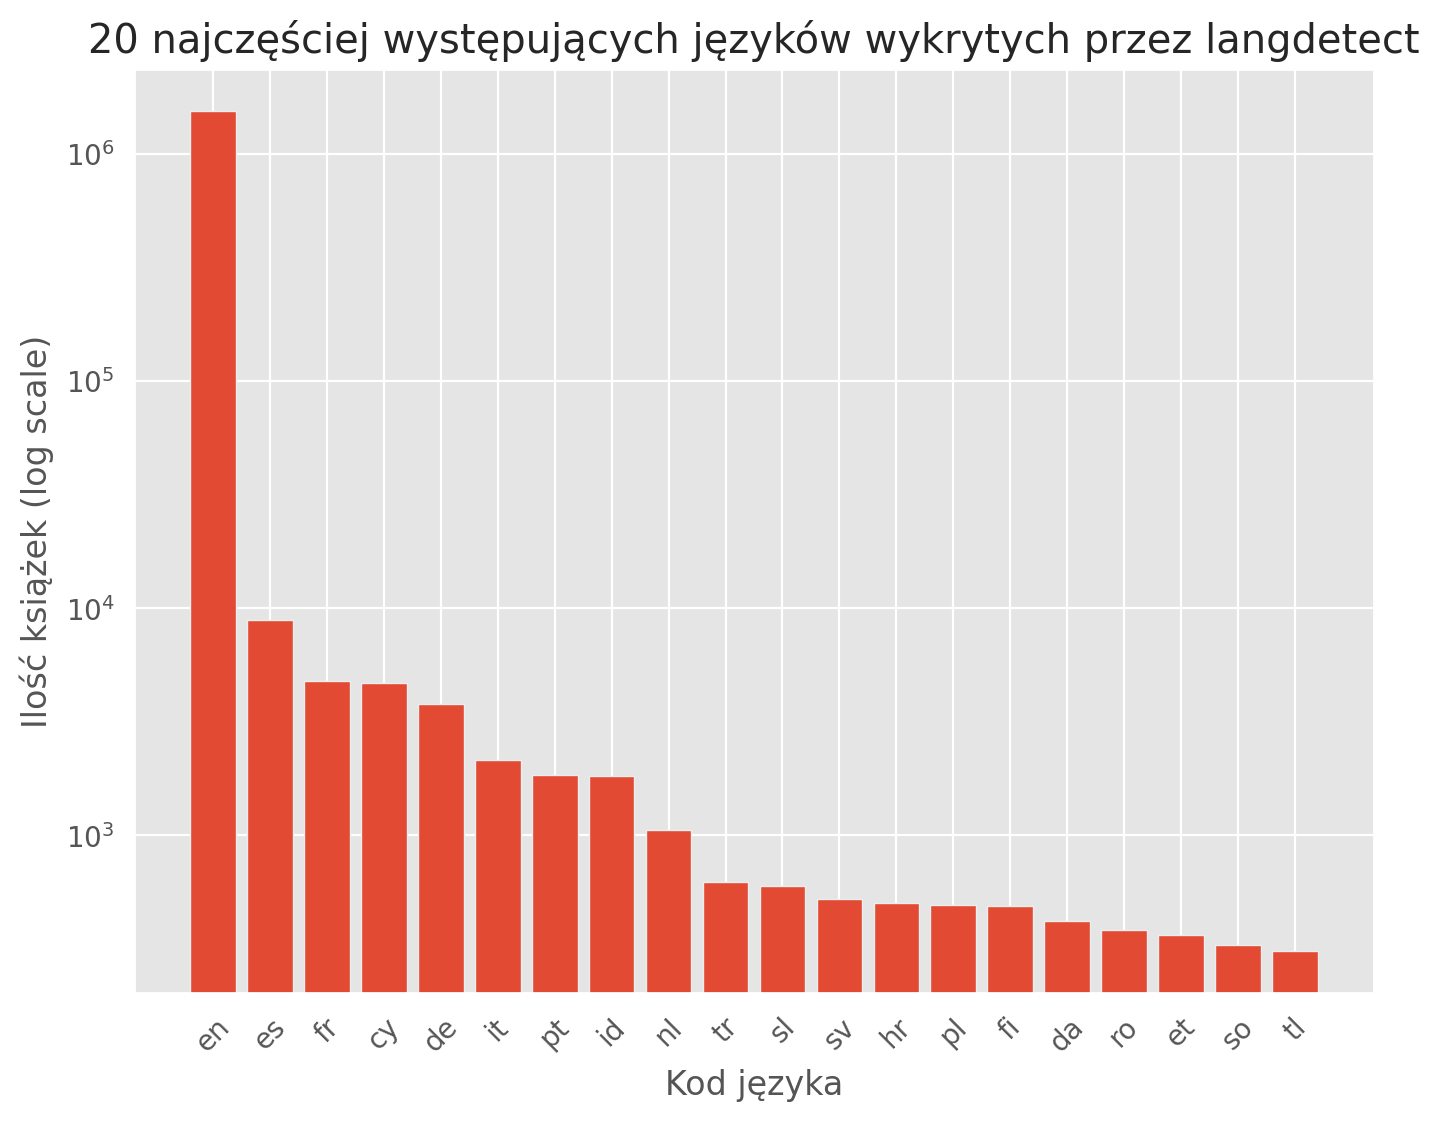

In [52]:
language_code_sorted = (
    df["detected_language"].value_counts().nlargest(20).sort_values(ascending=False)
)


plt.figure()
plt.bar(language_code_sorted.index, language_code_sorted.values, log=True)
plt.xlabel("Kod języka")
plt.ylabel("Ilość książek (log scale)")
plt.title("20 najczęściej występujących języków wykrytych przez langdetect")
plt.xticks(rotation=45)
plt.show()

In [52]:
df.drop(df[~df["detected_language"].isin(english_lang_codes)].index, inplace=True)

In [53]:
len(df) / 2360655

0.6516903147643345

# Oczyszczenie zescrapowanych danych i oznaczenie języka opisu

In [54]:
fresh_df.head(100)

,book_id,description,description_len
0,750454,What do wives expect from their husbands? Some...,497
1,750456,A young woman losing her vision rides the subw...,93
2,8217862,"In productive classrooms, teachers don't just ...",1317
3,24850274,NaN,0
4,16117516,Free Download,13
...,...,...,...
95,4352776,NaN,0
96,28669888,If you've avoided the prospect of marketing yo...,864
97,12752275,Practical Steps to a Deeper FaithSometimes fai...,556
98,18396714,NaN,0


In [55]:
fresh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483748 entries, 0 to 483747
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   book_id          483748 non-null  int64 
 1   description      399162 non-null  object
 2   description_len  483748 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 11.1+ MB


In [56]:
fresh_df["description"].isna().sum()

84586

In [57]:
fresh_df.dropna(inplace=True, subset=["description"])

In [58]:
fresh_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399162 entries, 0 to 483747
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   book_id          399162 non-null  int64 
 1   description      399162 non-null  object
 2   description_len  399162 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 12.2+ MB


In [59]:
@auto_pickle(unique_name="new_data_detected_language")
def add_language(dataframe):
    dataframe["detected_language"] = dataframe["description"].progress_apply(
        detect_language
    )
    return dataframe


fresh_df = add_language(fresh_df)

2024-04-20 14:39:35,549 - INFO - Loading 'data/pickled/add_language_new_data_detected_language_v1_.pkl' from file.
2024-04-20 14:39:36,153 - INFO - Loaded 'data/pickled/add_language_new_data_detected_language_v1_.pkl' from file pandas type.


In [60]:
fresh_df["detected_language"].value_counts(normalize=True, dropna=False)

detected_language
en      0.84
es      0.03
ar      0.02
fr      0.02
de      0.01
it      0.01
id      0.01
fa      0.01
pt      0.01
nl      0.00
af      0.00
tr      0.00
ja      0.00
fi      0.00
ru      0.00
pl      0.00
no      0.00
sv      0.00
bn      0.00
da      0.00
el      0.00
tl      0.00
vi      0.00
et      0.00
ro      0.00
hr      0.00
cs      0.00
ca      0.00
NaN     0.00
bg      0.00
lt      0.00
ta      0.00
zh-cn   0.00
th      0.00
sl      0.00
sk      0.00
hu      0.00
lv      0.00
so      0.00
hi      0.00
cy      0.00
ur      0.00
he      0.00
ko      0.00
ml      0.00
uk      0.00
sw      0.00
zh-tw   0.00
mr      0.00
sq      0.00
te      0.00
mk      0.00
ne      0.00
kn      0.00
gu      0.00
pa      0.00
Name: proportion, dtype: float64

Opisy książek mają 54 różnych języków, angielski to 84% wszystkich opisów.

In [61]:
fresh_df.dropna(inplace=True, subset=["detected_language"])

In [62]:
fresh_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398850 entries, 0 to 483747
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   book_id            398850 non-null  int64 
 1   description        398850 non-null  object
 2   detected_language  398850 non-null  object
dtypes: int64(1), object(2)
memory usage: 12.2+ MB


In [63]:
fresh_df["detected_language"].value_counts(normalize=True, dropna=False)

detected_language
en      0.84
es      0.03
ar      0.02
fr      0.02
de      0.01
it      0.01
id      0.01
fa      0.01
pt      0.01
nl      0.00
af      0.00
tr      0.00
ja      0.00
fi      0.00
ru      0.00
pl      0.00
no      0.00
sv      0.00
bn      0.00
da      0.00
el      0.00
tl      0.00
vi      0.00
et      0.00
ro      0.00
hr      0.00
cs      0.00
ca      0.00
bg      0.00
lt      0.00
ta      0.00
zh-cn   0.00
th      0.00
sl      0.00
sk      0.00
hu      0.00
lv      0.00
so      0.00
hi      0.00
cy      0.00
he      0.00
ur      0.00
ko      0.00
ml      0.00
uk      0.00
sw      0.00
zh-tw   0.00
mr      0.00
sq      0.00
te      0.00
mk      0.00
ne      0.00
kn      0.00
gu      0.00
pa      0.00
Name: proportion, dtype: float64

In [64]:
fresh_df.drop(
    fresh_df[~fresh_df["detected_language"].isin(english_lang_codes)].index,
    inplace=True,
)

In [65]:
fresh_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336399 entries, 0 to 483747
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   book_id            336399 non-null  int64 
 1   description        336399 non-null  object
 2   detected_language  336399 non-null  object
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


In [66]:
fresh_df["description_len"] = fresh_df["description"].progress_apply(lambda x: len(x))

  0%|          | 0/336399 [00:00<?, ?it/s]

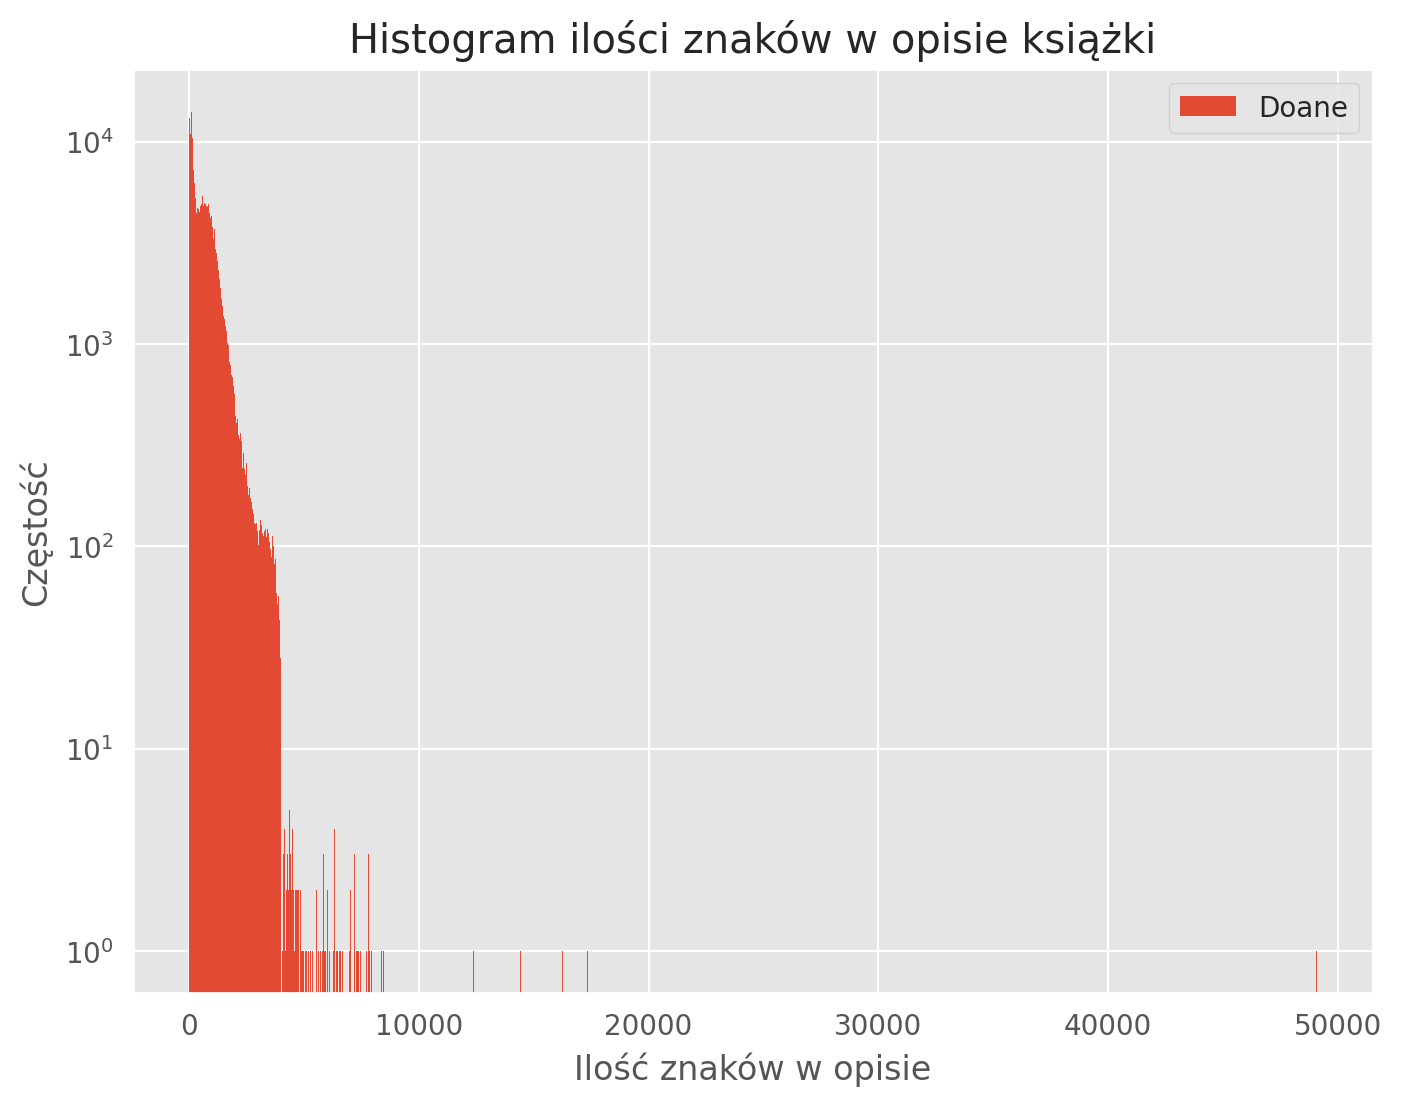

In [67]:
plt.style.use("ggplot")

plt.hist(
    fresh_df["description_len"],
    bins=np.histogram_bin_edges(fresh_df["description_len"], bins="fd").size,
    label="Doane",
    log=True,
    edgecolor="black",
    linewidth=0,
)
plt.xlabel("Ilość znaków w opisie")
plt.ylabel("Częstość")
plt.title("Histogram ilości znaków w opisie książki")
plt.legend()

# plt.tight_layout()
plt.show()

In [68]:
df = df.merge(fresh_df, on="book_id", how="left")
df["description"] = df["description_x"].combine_first(df["description_y"])
df.drop(columns=[col for col in df.columns if "_x" in col or "_y" in col], inplace=True)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538417 entries, 0 to 1538416
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   book_id             1538417 non-null  int64 
 1   title               1538414 non-null  object
 2   language_code       783875 non-null   object
 3   series              1538417 non-null  object
 4   similar_books       1538417 non-null  object
 5   url                 1538417 non-null  object
 6   description_tokens  1538417 non-null  int64 
 7   description         1538417 non-null  object
dtypes: int64(2), object(6)
memory usage: 93.9+ MB


In [70]:
df["description_len"] = df["description"].progress_apply(lambda x: len(x))

  0%|          | 0/1538417 [00:00<?, ?it/s]

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538417 entries, 0 to 1538416
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   book_id             1538417 non-null  int64 
 1   title               1538414 non-null  object
 2   language_code       783875 non-null   object
 3   series              1538417 non-null  object
 4   similar_books       1538417 non-null  object
 5   url                 1538417 non-null  object
 6   description_tokens  1538417 non-null  int64 
 7   description         1538417 non-null  object
 8   description_len     1538417 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 105.6+ MB


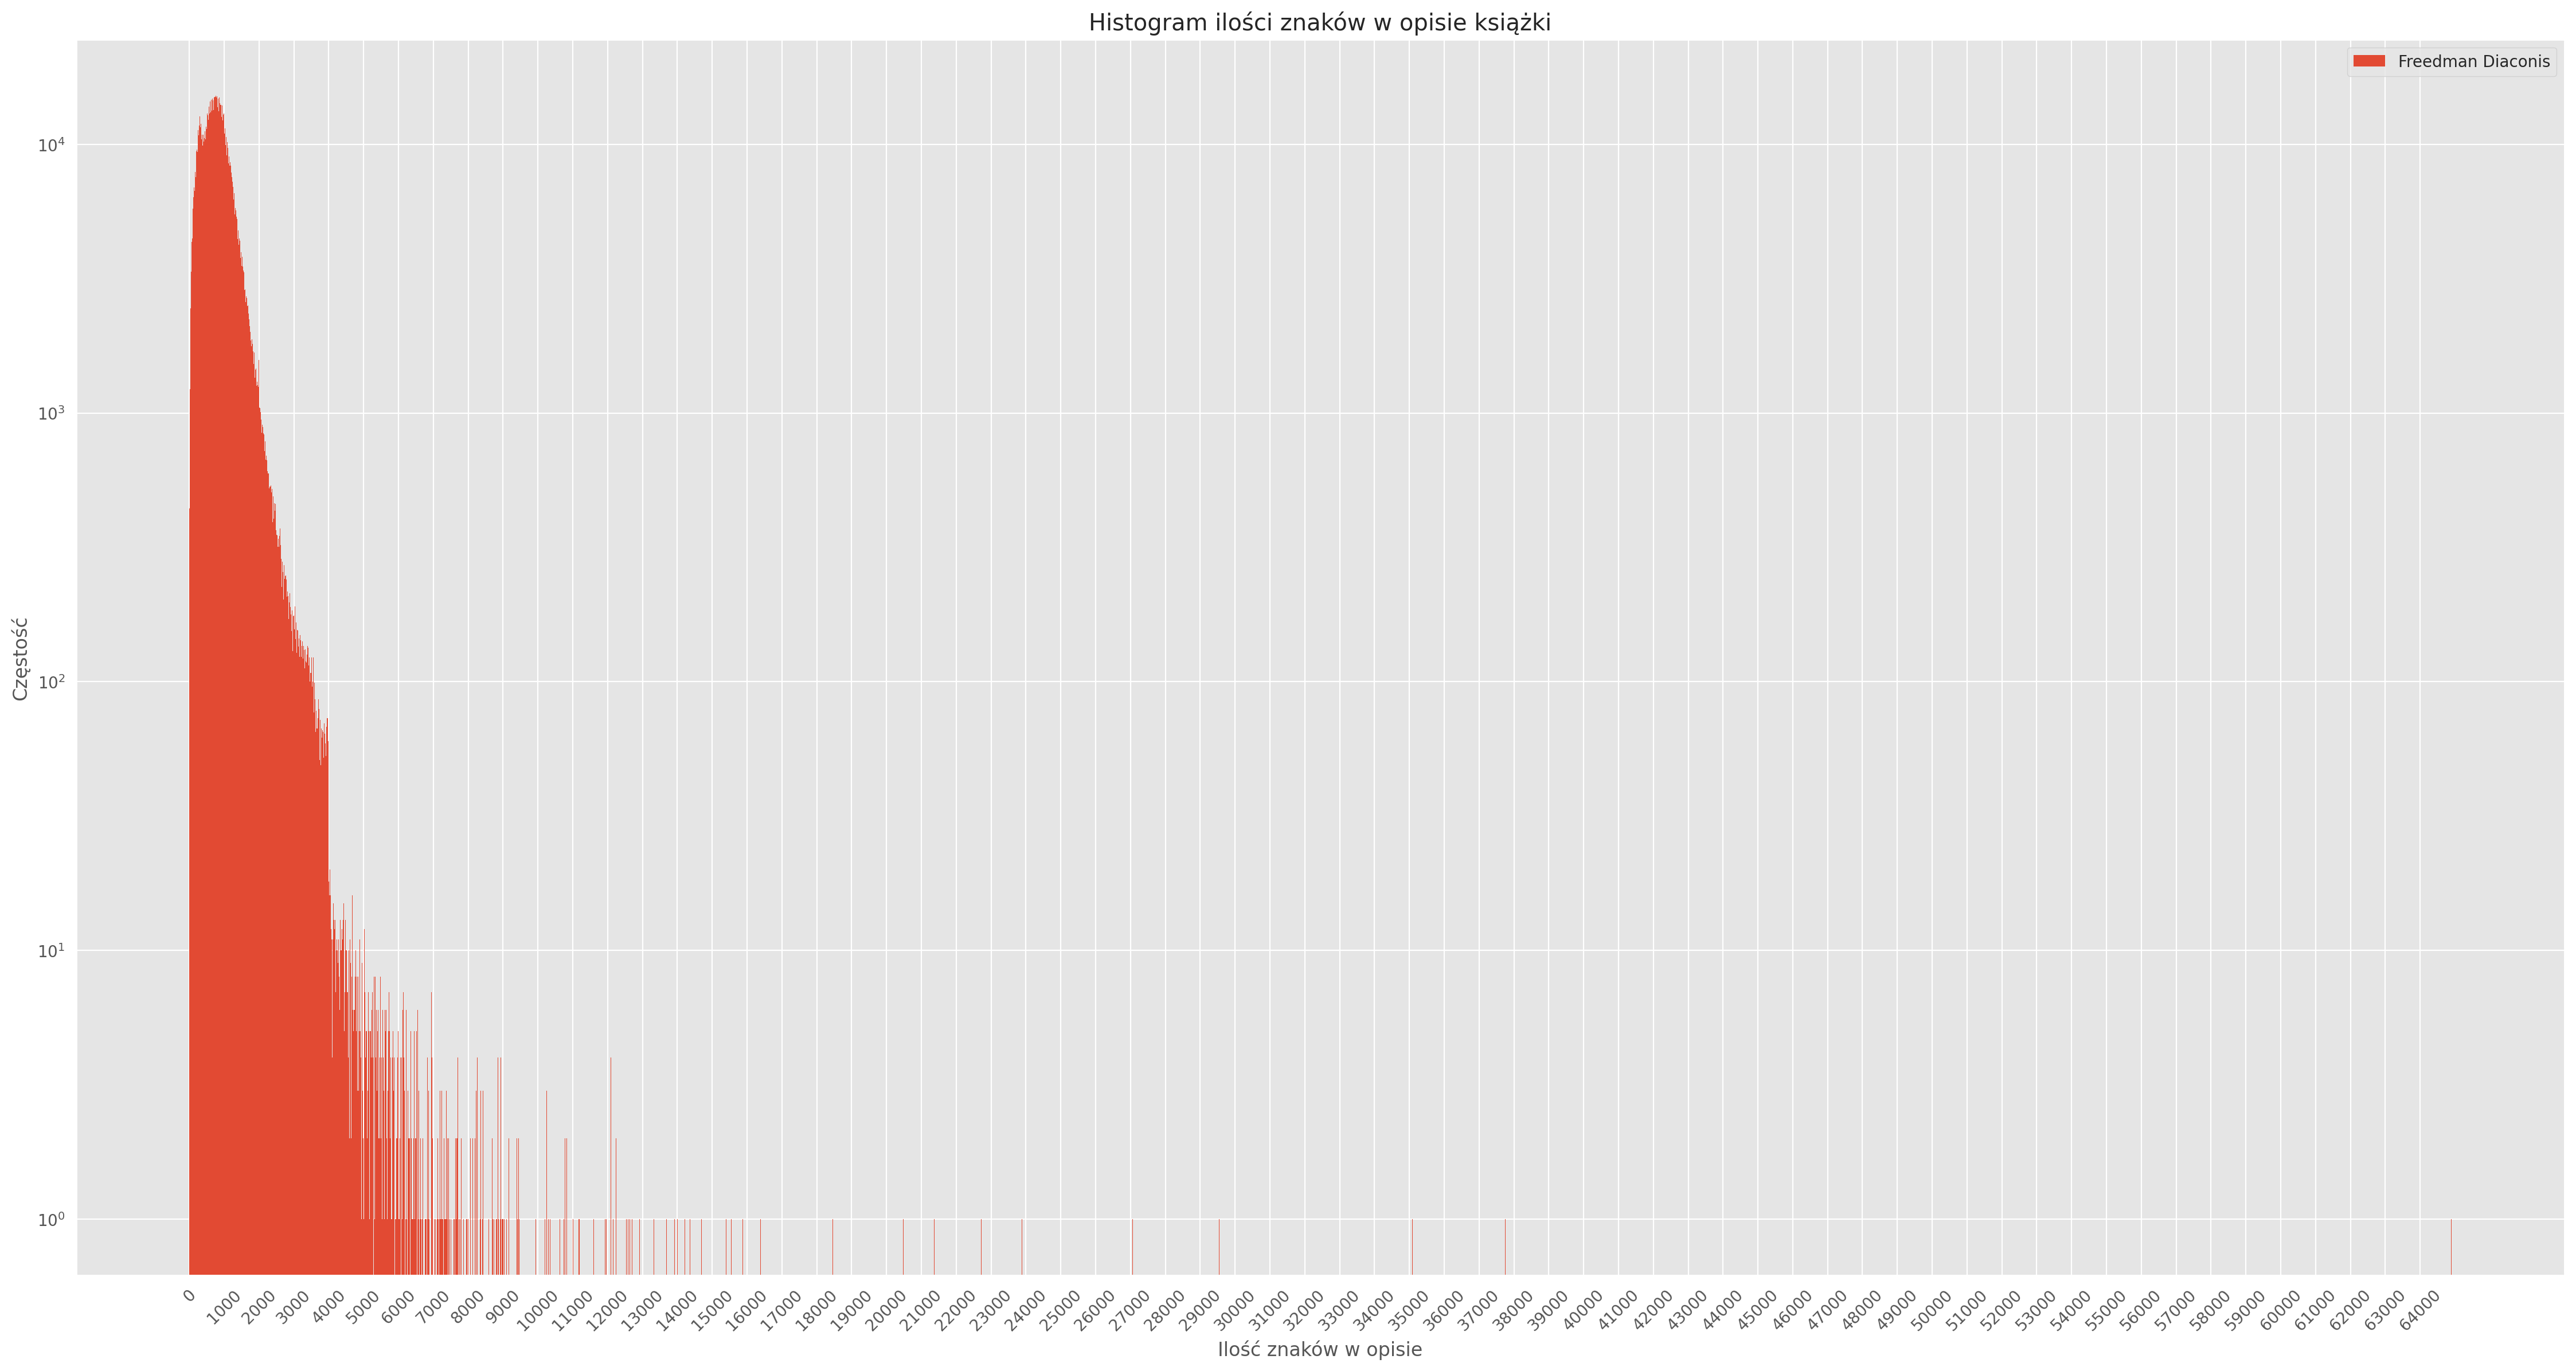

In [72]:
plt.style.use("ggplot")
plt.figure(figsize=(28, 14))

plt.hist(
    df["description_len"],
    bins=np.histogram_bin_edges(df["description_len"], bins="fd").size,
    label="Freedman Diaconis",
    log=True,
    edgecolor="black",
    linewidth=0,
)

plt.xlabel("Ilość znaków w opisie")
plt.ylabel("Częstość")
plt.title("Histogram ilości znaków w opisie książki")
tick_positions = range(0, int(df["description_len"].max()) + 1, 1000)
tick_labels = [str(x) for x in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.legend()

# plt.tight_layout()
plt.show()

In [73]:
df["description_len"].describe()

count   1538417.00
mean        860.68
std         565.61
min           1.00
25%         488.00
50%         784.00
75%        1107.00
max       64897.00
Name: description_len, dtype: float64

In [74]:
df["description_len"].quantile(0.99)

2769.0

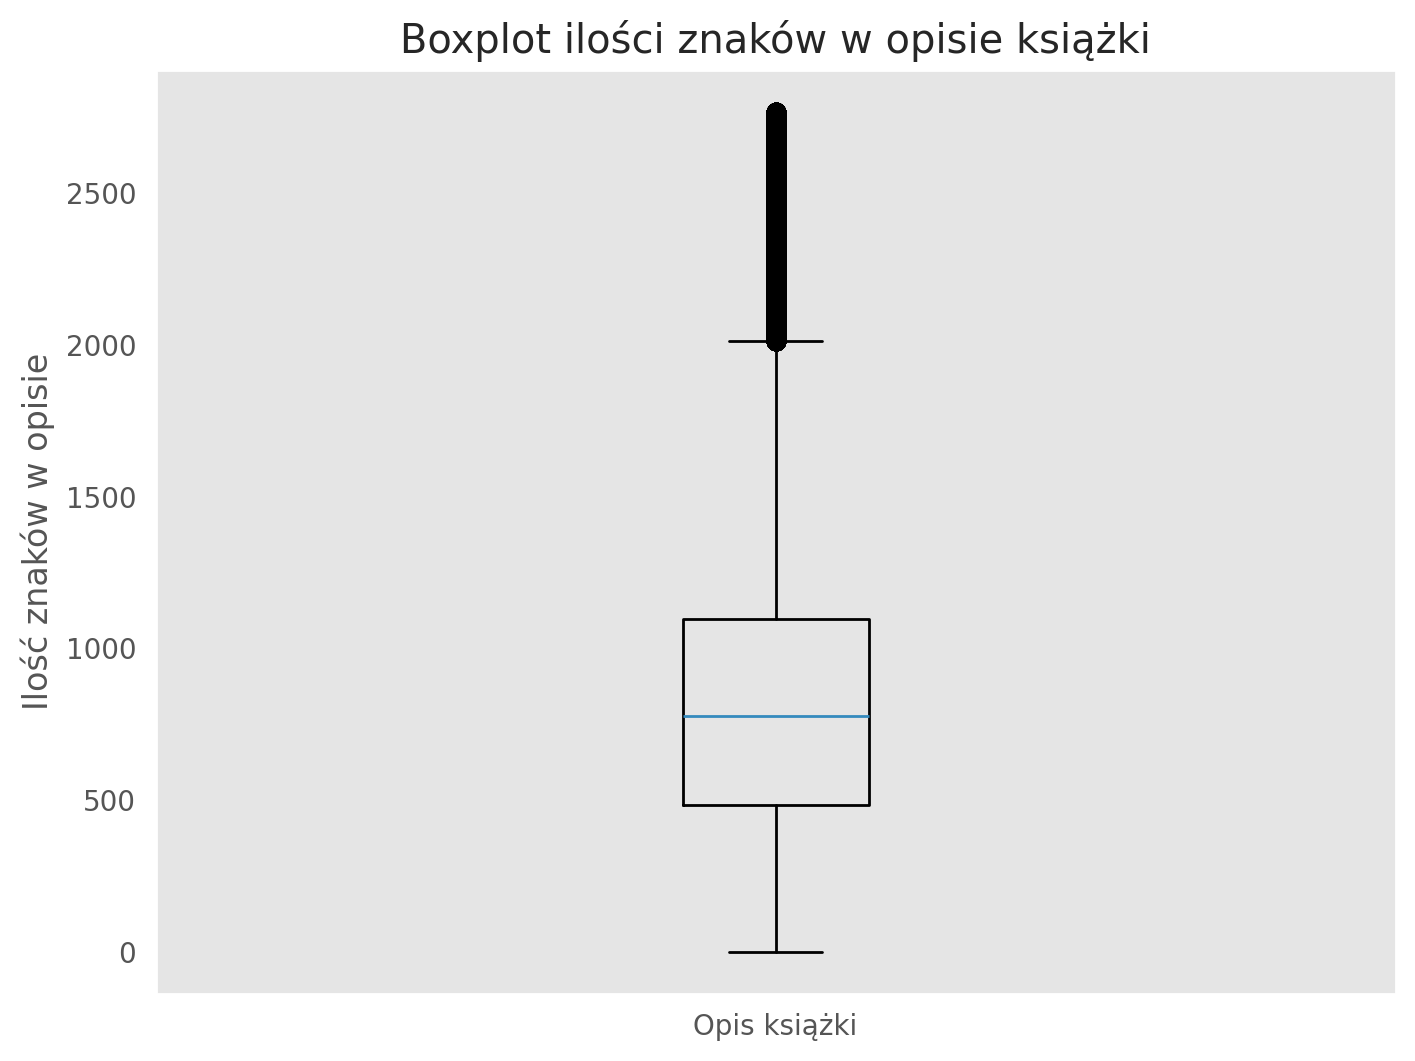

In [75]:
# boxplot for description length less than 1024

plt.figure()
plt.boxplot(
    df[df["description_len"] < df["description_len"].quantile(0.99)]["description_len"]
)
plt.ylabel("Ilość znaków w opisie")
plt.title("Boxplot ilości znaków w opisie książki")
plt.xticks([1], ["Opis książki"])  # Adjust the x-ticks if necessary
plt.grid(False)  # Optionally, you can turn off the grid for a cleaner look
plt.show()


# df.boxplot(column=['description_len'])

In [76]:
# count empty descriptions

df["description_len"].quantile(0.01)

71.0

In [77]:
# dropping rows with description length less than 0.01 quantile

df.drop(
    df[df["description_len"] < df["description_len"].quantile(0.01)].index, inplace=True
)

In [78]:
df["index"] = df.index

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1523147 entries, 0 to 1538416
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   book_id             1523147 non-null  int64 
 1   title               1523144 non-null  object
 2   language_code       775583 non-null   object
 3   series              1523147 non-null  object
 4   similar_books       1523147 non-null  object
 5   url                 1523147 non-null  object
 6   description_tokens  1523147 non-null  int64 
 7   description         1523147 non-null  object
 8   description_len     1523147 non-null  int64 
 9   index               1523147 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 127.8+ MB


In [80]:
# save the cleaned data to a new file if not already saved
if not (
    os.path.exists("data/goodreads_cleaned_books.csv.gz")
    and os.path.exists("data/goodreads_cleaned_books_desc.csv.gz")
):
    df.to_csv(
        "data/goodreads_cleaned_books.csv.gz",
        compression="gzip",
        index=True,
        encoding="utf-8",
    )
    df[["index", "book_id", "description"]].to_csv(
        "data/goodreads_cleaned_books_desc.csv.gz",
        compression="gzip",
        index=True,
        encoding="utf-8",
    )

In [81]:
small_df = df.sample(100, random_state=308171)
small_df.to_csv(
    "data/small_goodreads_cleaned_books.csv.gz",
    compression="gzip",
    index=True,
    encoding="utf-8",
)
small_df.to_csv("data/small_goodreads_cleaned_books.csv", index=True, encoding="utf-8")
small_df[["book_id", "description"]].to_csv(
    "data/small_goodreads_cleaned_books_desc.csv.gz",
    compression="gzip",
    index=True,
    encoding="utf-8",
)
small_df[["book_id", "description"]].to_csv(
    "data/small_goodreads_cleaned_books_desc.csv", index=True, encoding="utf-8"
)

# Fix errors and extend cleaned and summarized data

In [82]:
import pandas as pd
import os

In [84]:
df.drop(
    columns=["Unnamed: 0", "index", "description_len", "description_tokens"],
    inplace=True,
)

In [85]:
df.head()

,book_id,title,language_code,series,similar_books,url,description
0,1333909,Good Harbor,NaN,[],"['8709549', '17074050', '28937', '158816', '22...",https://www.goodreads.com/book/show/1333909.Go...,"Anita Diamant's international bestseller ""The ..."
1,6066819,Best Friends Forever,eng,[],"['6604176', '6054190', '2285777', '82641', '75...",https://www.goodreads.com/book/show/6066819-be...,Addie Downs and Valerie Adler were eight when ...
2,287141,The Aeneid for Boys and Girls,NaN,[],[],https://www.goodreads.com/book/show/287141.The...,"Relates in vigorous prose the tale of Aeneas, ..."
3,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,NaN,['151854'],"['948696', '439885', '274955', '12978730', '37...",https://www.goodreads.com/book/show/6066812-al...,"To Kara's astonishment, she discovers that a p..."
4,34883016,Playmaker: A Venom Series Novella,NaN,[],[],https://www.goodreads.com/book/show/34883016-p...,Secrets. Sometimes keeping them in confidence ...


In [86]:
# show duplicated rows
df[df.duplicated(subset=["book_id"], keep=False)]

,book_id,title,language_code,series,similar_books,url,description
55362,278528,"The Phantom Freighter (Hardy Boys, #26)",eng,['154704'],"['861989', '1162699', '862076']",https://www.goodreads.com/book/show/278528.The...,The Hardy brothers embark on a freighter trip ...
55363,278528,"The Phantom Freighter (Hardy Boys, #26)",eng,['154704'],"['861989', '1162699', '862076']",https://www.goodreads.com/book/show/278528.The...,The Hardy brothers embark on a freighter trip ...


In [87]:
# remove duplicated rows
df.drop_duplicates(subset=["book_id"], inplace=True)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1508316 entries, 0 to 1508316
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   book_id        1508316 non-null  int64 
 1   title          1508312 non-null  object
 2   language_code  769198 non-null   object
 3   series         1508316 non-null  object
 4   similar_books  1508316 non-null  object
 5   url            1508316 non-null  object
 6   description    1508316 non-null  object
dtypes: int64(1), object(6)
memory usage: 92.1+ MB


In [78]:
if not os.path.exists("data/goodreads_cleaned_books_summarized.csv.gz"):
    gdown.download(
        "https://drive.google.com/file/d/1DgiGnkMJFQlO2thW51b3e4Ipu5rc0R3U/view?usp=drive_link",
        output="data/goodreads_cleaned_books_summarized.csv.gz",
        quiet=False,
        fuzzy=True,
    )
        

df = pd.read_csv(
    "data/goodreads_cleaned_books_summarized.csv.gz", compression="gzip", index_col=0
)
df.head()

Downloading...
From (original): https://drive.google.com/uc?id=1DgiGnkMJFQlO2thW51b3e4Ipu5rc0R3U
From (redirected): https://drive.google.com/uc?id=1DgiGnkMJFQlO2thW51b3e4Ipu5rc0R3U&confirm=t&uuid=d1013b68-736f-4024-abba-d18e03923c1e
To: /home/dawid/PycharmProjects/Analysis/data/goodreads_cleaned_books_summarized.csv.gz

  0%|          | 0.00/701M [00:00<?, ?B/s]
  0%|          | 524k/701M [00:00<09:38, 1.21MB/s]
  0%|          | 2.10M/701M [00:00<02:33, 4.57MB/s]
  1%|          | 3.67M/701M [00:00<01:39, 7.04MB/s]
  1%|          | 4.72M/701M [00:00<01:49, 6.39MB/s]
  1%|          | 5.77M/701M [00:01<01:45, 6.58MB/s]
  1%|          | 6.82M/701M [00:01<01:42, 6.77MB/s]
  1%|          | 7.86M/701M [00:01<01:31, 7.55MB/s]
  1%|▏         | 8.91M/701M [00:01<01:28, 7.87MB/s]
  2%|▏         | 11.0M/701M [00:01<01:04, 10.6MB/s]
  2%|▏         | 12.6M/701M [00:01<01:00, 11.4MB/s]
  2%|▏         | 14.2M/701M [00:01<00:58, 11.7MB/s]
  2%|▏         | 16.3M/701M [00:01<00:51, 13.3MB/s]
  3%|▎      

KeyboardInterrupt: 

In [89]:
df.reset_index(inplace=True)

In [90]:
df.head()

,index,book_id,title,language_code,series,similar_books,url,description
0,0,1333909,Good Harbor,NaN,[],"['8709549', '17074050', '28937', '158816', '22...",https://www.goodreads.com/book/show/1333909.Go...,"Anita Diamant's international bestseller ""The ..."
1,1,6066819,Best Friends Forever,eng,[],"['6604176', '6054190', '2285777', '82641', '75...",https://www.goodreads.com/book/show/6066819-be...,Addie Downs and Valerie Adler were eight when ...
2,2,287141,The Aeneid for Boys and Girls,NaN,[],[],https://www.goodreads.com/book/show/287141.The...,"Relates in vigorous prose the tale of Aeneas, ..."
3,3,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,NaN,['151854'],"['948696', '439885', '274955', '12978730', '37...",https://www.goodreads.com/book/show/6066812-al...,"To Kara's astonishment, she discovers that a p..."
4,4,34883016,Playmaker: A Venom Series Novella,NaN,[],[],https://www.goodreads.com/book/show/34883016-p...,Secrets. Sometimes keeping them in confidence ...


In [91]:
# save to file
if not os.path.exists("data/goodreads_cleaned_books_summarized_fix.csv.gz"):
    df.to_csv(
        "data/goodreads_cleaned_books_summarized_fix.csv.gz",
        compression="gzip",
        encoding="utf-8",
    )